In [1]:
#to suppress all warnings and make more readable the notebook
from IPython.display import HTML
HTML('''<script>
code_show_err=false; 
function code_toggle_err() {
 if (code_show_err){
 $('div.output_stderr').hide();
 } else {
 $('div.output_stderr').show();
 }
 code_show_err = !code_show_err
} 
$( document ).ready(code_toggle_err);
</script>
To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>.''')

# This is TH+500

In [2]:
import sys
sys.path.insert(0, "/media/giuseppec/25F62A4E5FEED162/work/temporalis_update/brightway2-temporalis_last")
# sys.path.insert(0, "/media/giuseppec/25F62A4E5FEED162/work/temporalis_update/brightway2-temporalis_chris")

In [3]:
import warnings
warnings.filterwarnings('ignore')

import string
from brightway2 import *
from bw2temporalis import *
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import pickle
from bw2temporalis.dyn_methods.constants import co2_rf_td
# import palettable


%matplotlib inline
# list(projects)

#to make everything bold see https://stackoverflow.com/a/43111170/4929813
# plt.rcParams["font.weight"] = "bold"
# plt.rcParams["axes.labelweight"] = "bold"

projects.set_current('temporalis_demo')

# compare static and dynamic LCA using static LCIA 
`Here let's first check the difference in the cumulative results between the static and the dynamic LCA using the same LCIA method`

In [4]:
#calculate static lca for each time horizon (used in plot below)
FU={('tempo', 'glulam_FU'): 1}
all_meth={20:('IPCC 2007', 'climate change', 'GWP 20a'),
          100:('IPCC 2007', 'climate change', 'GWP 100a'),
          500:('IPCC 2007', 'climate change', 'GWP 500a')}
res={}
for yr,m in all_meth.items():
    l = LCA(FU, m)
    l.lci()
    l.lcia()
    res[yr]=l.score 
    print('score static LCA with GWP{}: '.format(yr), round(l.score,2))

    dlca_st = DynamicLCA(FU, m,t0=np.datetime64('2017-01-01'),cutoff=0.00000001,loop_cutoff=10)
    timel_st=dlca_st.calculate()
    yr_st,res_st=timel_st.characterize_static(m,cumulative=True)
    print('results dynamic with LCA with GWP{}: '.format(yr),round(res_st[-1],2))
    print("difference in percentage between the two: ", round((res_st[-1]-l.score)/(res_st[-1])*100,2))
    print()

score static LCA with GWP20:  -222.46
results dynamic with LCA with GWP20:  -222.49
difference in percentage between the two:  0.02

score static LCA with GWP100:  -288.9
results dynamic with LCA with GWP100:  -288.93
difference in percentage between the two:  0.01

score static LCA with GWP500:  -314.23
results dynamic with LCA with GWP500:  -314.27
difference in percentage between the two:  0.01



# dynamic LCI with static LCIA

In [5]:
fu={('tempo', 'glulam_FU'): 1}
method=('IPCC 2007', 'climate change', 'GWP 500a')
dlca = DynamicLCA(fu, method,t0=np.datetime64('2017-01-01'),cutoff=0.00000001,loop_cutoff=10,group=True)
timeline=dlca.calculate()
y_st,r_st=timeline.characterize_static(method,cumulative=True)

In [6]:
#change name cols for graph and associate colors
names_cols={
'sawing, softwood': 'Sawnwood production',
'market for sawlog and veneer log, softwood, measured as solid wood under bark':'Raw wood production',
'glulam_eol': 'Glulam use-EOL',# 
 'glulam_prod': 'Glulam production',} 

#create dict with cols:colors
columns = ['Glulam production',
 'Glulam use-EOL',
 'Raw wood production',
 'Sawnwood production',
 'Total',
 'Total no biogenic']
colors = {'Glulam production':'b',
 'Glulam use-EOL':'gold',
 'Raw wood production':'g',
 'Sawnwood production':'r',
 'Total':'k',
'Total no biogenic':'k'}

In [7]:
#create dict with results by process

st_CF={}
for x in timeline.processes():
    yr_pr_st,res_pr_st=timeline.timeline_for_activity(x).characterize_static(method,cumulative=False)
    st_CF[get_activity(x)['name']]=[yr_pr_st,res_pr_st]

In [8]:
#convert dict with results to dataframe
df_st_CF=pd.DataFrame({k:pd.Series(v[1], index=v[0]) for (k,v) in st_CF.items() if len(v[0])>0})
df_st_CF.index=df_st_CF.index.map(int)#to have int in x axis


# # when cumulative=False in characterize_static
df_st_CF=df_st_CF.cumsum().ffill() 
#fill gaps in years and take only 500 yrs
df_st_CF=df_st_CF.reindex(range(df_st_CF.index.min(),2017+501),method='ffill').loc[:2017+501].ffill()#correct

lenght=len(df_st_CF) #lenght of the TH

# create tot
tot_st=pd.Series(index=[int(x) for x in  y_st],data=r_st)

#fill gaps in years and take only 500 yrs
tot_st=tot_st.reindex(range(tot_st.index.min(),2017+501),method='ffill').loc[:2017+501] #correct



In [9]:
#rename columns
df_st_CF.rename(columns=names_cols,inplace=True)

#merge duplicate columns
df_st_CF=df_st_CF.T.groupby(df_st_CF.T.index).sum().T

#reorder cols for better graph
st_cols_order=[]
for index, row in df_st_CF.iterrows():
    for x,y in row.iteritems():
        if pd.notnull(y) and x not in st_cols_order:
            st_cols_order.append(x)

df_st_CF = df_st_CF[st_cols_order]


    

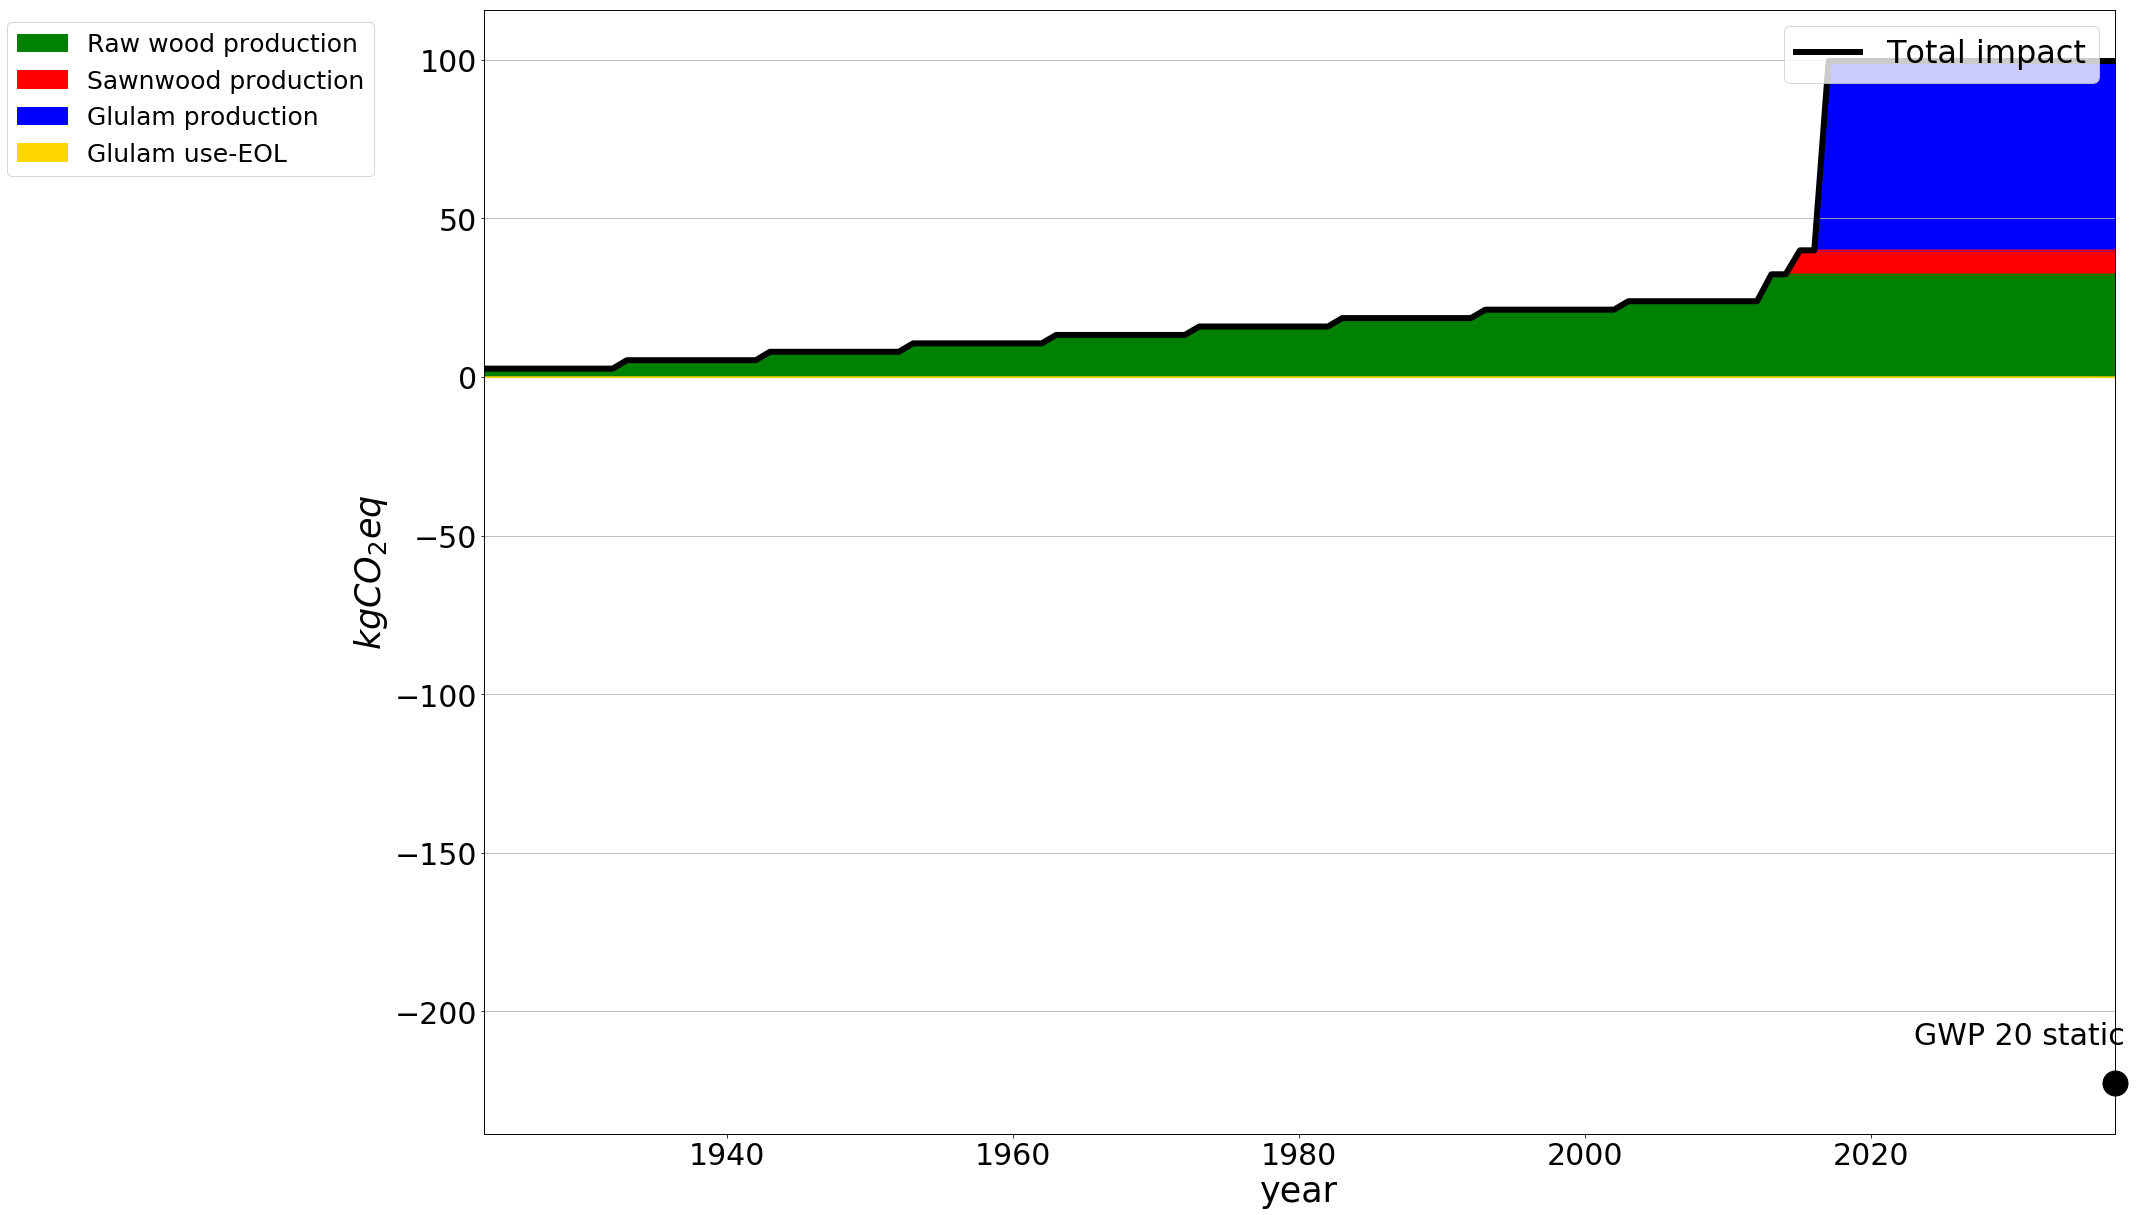

In [10]:
#plot 20 years
size_font=30


fig, ax = plt.subplots(figsize=(11.69*2.5,8.27*2.5))#(33,18))
ax2 = ax.twiny() #needed when overlaying barplot, see https://stackoverflow.com/a/24237358/4929813

#plot
df_st_CF.loc[:2017+20].plot.area(stacked=True,legend=False,fontsize=size_font,ax=ax,color=[colors[i] for i in df_st_CF.columns])#,colormap='Set3') #this is correct
tot_st.iloc[:len(df_st_CF.loc[:2017+20])].plot(linestyle='-', linewidth=6,color='black',legend=False,fontsize=size_font)

#show horizontal grids
ax.grid(True,axis='y')

#adjsut legend
#correct
ax.legend(bbox_to_anchor=(-0.3, 1),fontsize=size_font-5, loc='upper left', ncol=1) #put it outside the graph
ax2.legend(["Total impact"],fontsize=size_font+2,loc='upper right')


#x-ylabel
ax.set_ylabel('$kg CO_2eq$',fontsize=size_font+5)
ax.set_xlabel('year',fontsize=size_font+5)

#remove extra ticks
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)


#####ADD STATIC RESULTS

#calculate static lca for each time horizon (used in plot below)
FU={('tempo', 'glulam_FU'): 1}
all_meth={20:('IPCC 2007', 'climate change', 'GWP 20a')
         }
res={}
for yr,m in all_meth.items():
    l = LCA(FU, m)
    l.lci()
    l.lcia()
    res[yr]=l.score 

#draw vertical lines ad circles
line = ax2.lines[0] 
zero=line.get_xdata()[0]
xcoords = [zero+20]
    
#this starting from 2017
for xc in xcoords:
    ax2.plot([xc-zero+2017], [res[xc-zero]], 'k.', markersize=50.0,clip_on=False) #circles
    ax2.annotate('GWP {} static'.format(xc-zero),
             xy=(xc+80, res[xc-zero]+12 ), 
             size=size_font
            )

#                  xy=(xc-60 if (xc-zero)==500 else xc+70, res[xc-zero]-20 ), 



# # need to put this before show otherwise return blank fig see https://stackoverflow.com/a/21884187/4929813
# # #for paper
# plt.savefig('/media/giuseppec/25F62A4E5FEED162/work/papers/temporalis_paper/pictures/results_st.eps', format='eps',dpi=300,bbox_inches='tight')
# plt.savefig('/media/giuseppec/25F62A4E5FEED162/work/papers/temporalis_paper/pictures/results_st.svg', format='svg',dpi=300,bbox_inches='tight')
# plt.savefig('/media/giuseppec/25F62A4E5FEED162/work/papers/temporalis_paper/pictures/results_st.png', format='png',dpi=500,bbox_inches='tight')

plt.show()


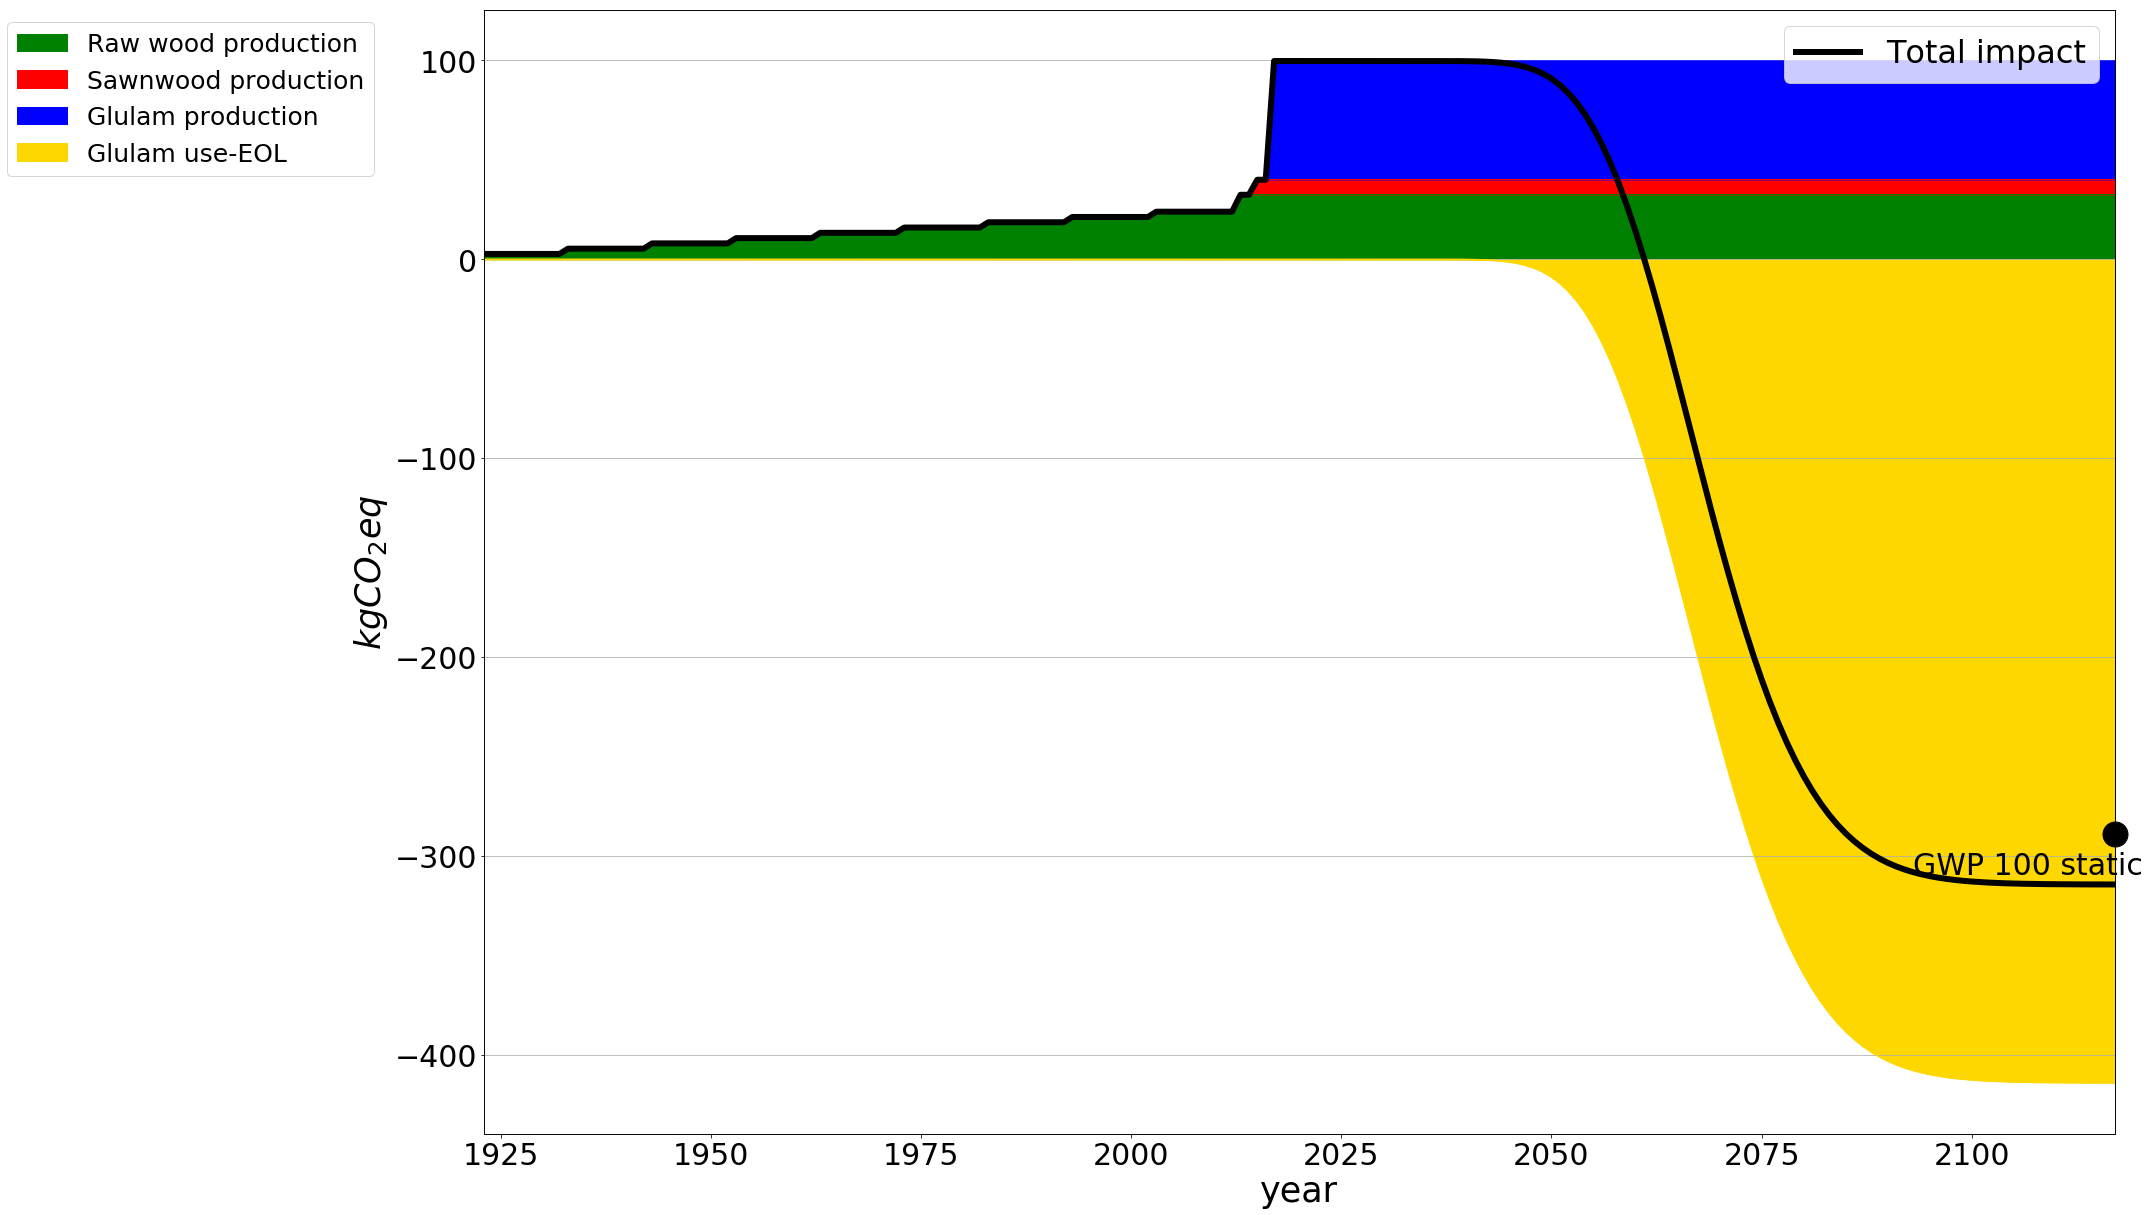

In [11]:
#plot 100 years
size_font=30


fig, ax = plt.subplots(figsize=(11.69*2.5,8.27*2.5))#(33,18))
ax2 = ax.twiny() #needed when overlaying barplot, see https://stackoverflow.com/a/24237358/4929813

#plot
# df_st_CF.plot(kind='bar',stacked=True,legend=False,width=1.1,fontsize=size_font,ax=ax)#,colormap='Paired')
df_st_CF.loc[:2017+100].plot.area(stacked=True,legend=False,fontsize=size_font,ax=ax,color=[colors[i] for i in df_st_CF.columns])#,colormap='Set3') #this is correct
tot_st.iloc[:len(df_st_CF.loc[:2017+100])].plot(linestyle='-', linewidth=6,color='black',legend=False,fontsize=size_font)

#show horizontal grids
ax.grid(True,axis='y')

#adjsut legend
#correct
ax.legend(bbox_to_anchor=(-0.3, 1),fontsize=size_font-5, loc='upper left', ncol=1) #put it outside the graph
ax2.legend(["Total impact"],fontsize=size_font+2,loc='upper right')


#x-ylabel
ax.set_ylabel('$kg CO_2eq$',fontsize=size_font+5)
ax.set_xlabel('year',fontsize=size_font+5)

#remove extra ticks
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)


#####ADD STATIC RESULTS

#calculate static lca for each time horizon (used in plot below)
FU={('tempo', 'glulam_FU'): 1}
all_meth={100:('IPCC 2007', 'climate change', 'GWP 100a'),

         }
res={}
for yr,m in all_meth.items():
    l = LCA(FU, m)
    l.lci()
    l.lcia()
    res[yr]=l.score 

#draw vertical lines ad circles
line = ax2.lines[0] 
zero=line.get_xdata()[0]
xcoords = [zero+100]
    
#this starting from 2017
for xc in xcoords:
        ax2.plot([xc-zero+2017], [res[xc-zero]], 'k.', markersize=50.0,clip_on=False) #circles
        ax2.annotate('GWP {} static'.format(xc-zero),
                 xy=(xc-60 if (xc-zero)==500 else xc+70, res[xc-zero]-20 ), 
                 size=size_font
                )




# # need to put this before show otherwise return blank fig see https://stackoverflow.com/a/21884187/4929813
# # #for paper
# plt.savefig('/media/giuseppec/25F62A4E5FEED162/work/papers/temporalis_paper/pictures/results_st.eps', format='eps',dpi=300,bbox_inches='tight')
# plt.savefig('/media/giuseppec/25F62A4E5FEED162/work/papers/temporalis_paper/pictures/results_st.svg', format='svg',dpi=300,bbox_inches='tight')
# plt.savefig('/media/giuseppec/25F62A4E5FEED162/work/papers/temporalis_paper/pictures/results_st.png', format='png',dpi=500,bbox_inches='tight')

plt.show()


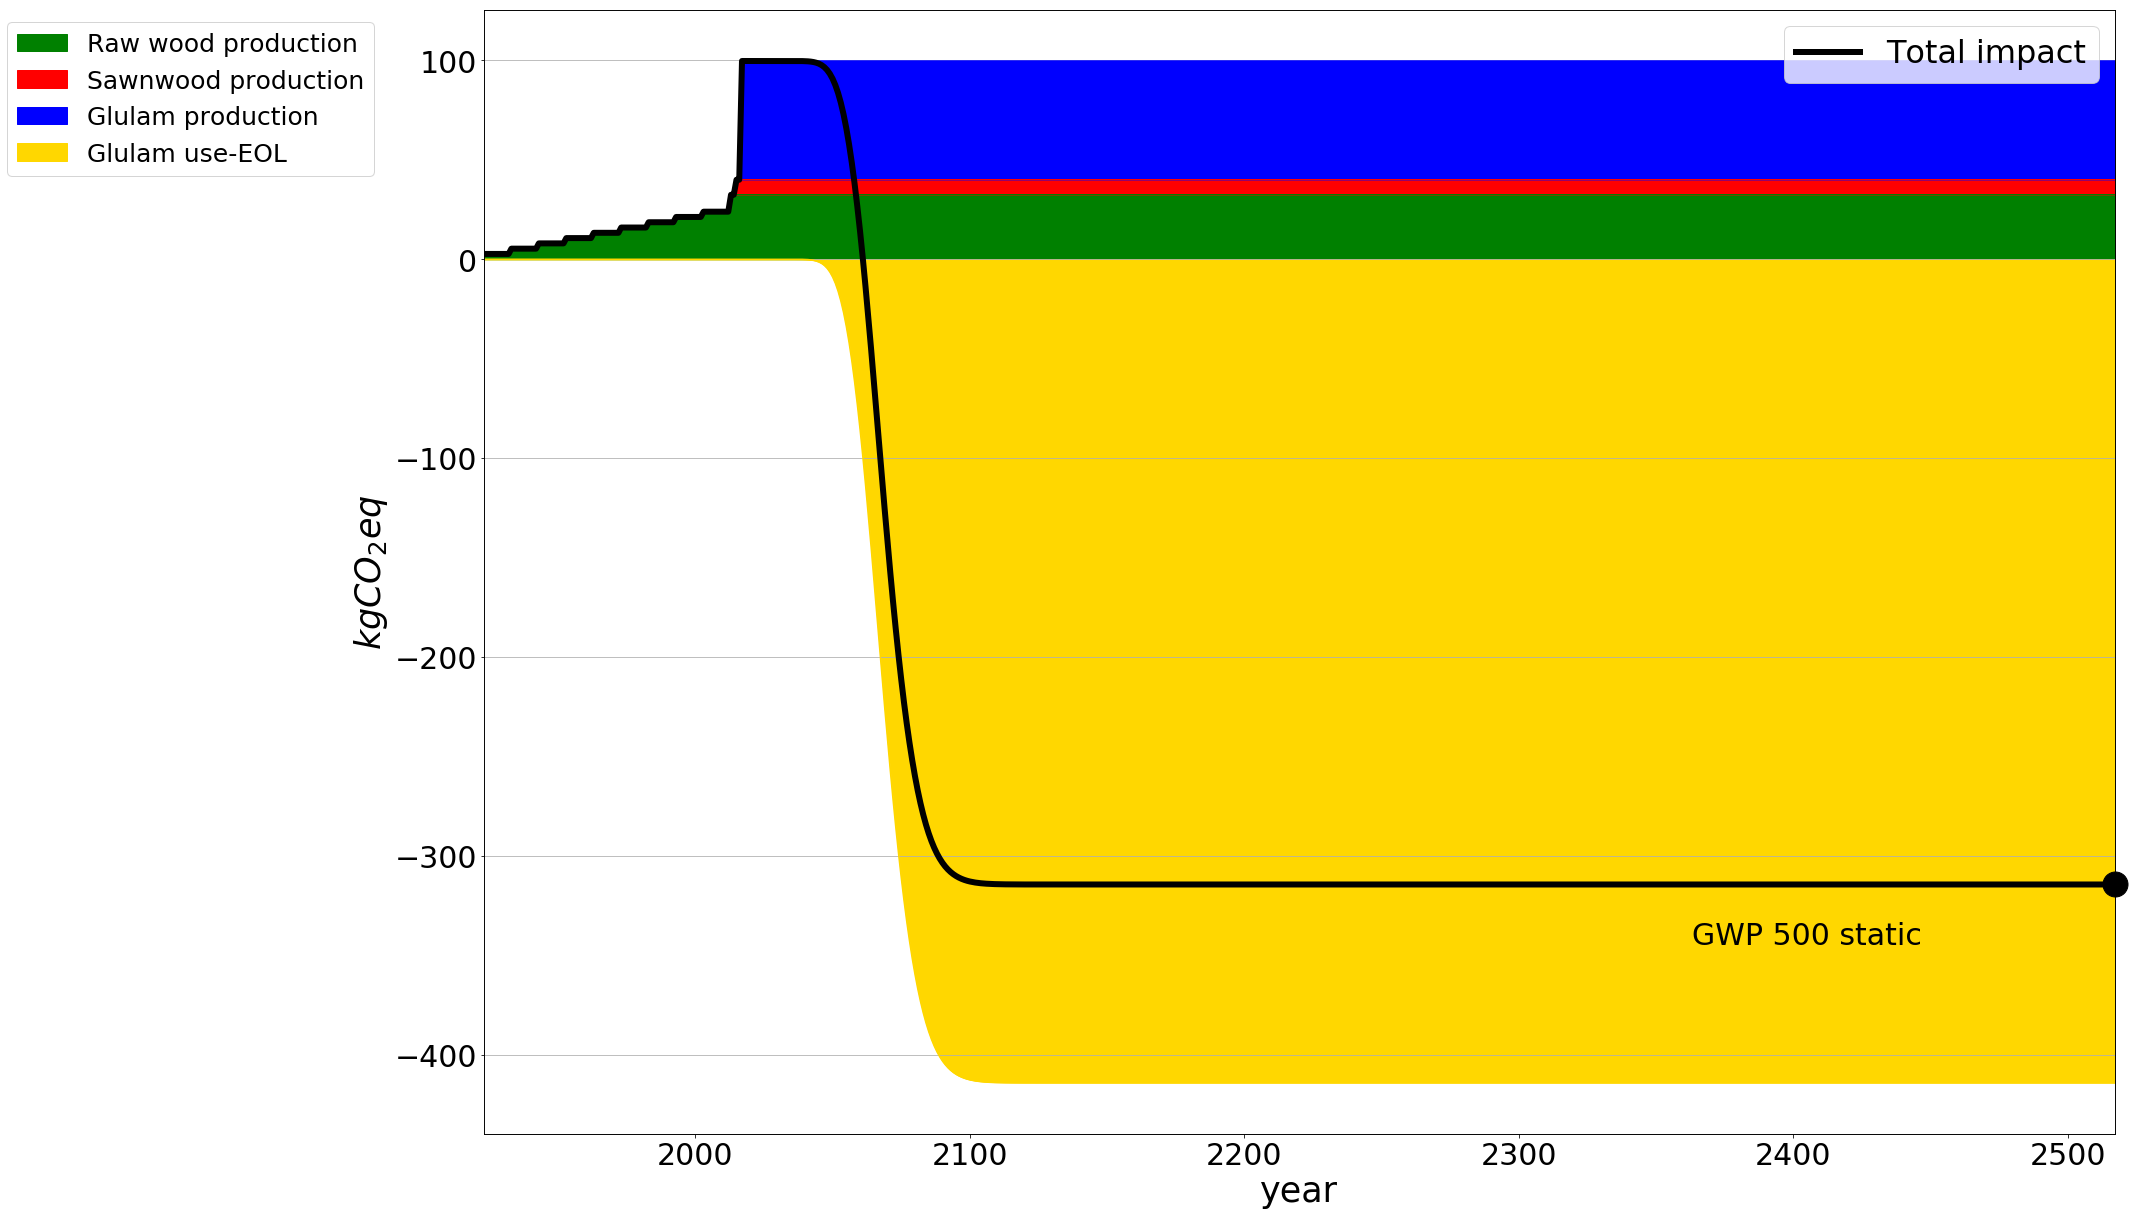

In [12]:
#plot 500 years
size_font=30


#to make everything bold see https://stackoverflow.com/a/43111170/4929813
# plt.rcParams["font.weight"] = "bold"
# plt.rcParams["axes.labelweight"] = "bold"

fig, ax = plt.subplots(figsize=(11.69*2.5,8.27*2.5))#(33,18))
ax2 = ax.twiny() #needed when overlaying barplot, see https://stackoverflow.com/a/24237358/4929813

#plot
# df_st_CF.plot(kind='bar',stacked=True,legend=False,width=1.1,fontsize=size_font,ax=ax)#,colormap='Paired')
df_st_CF.plot.area(stacked=True,legend=False,fontsize=size_font,ax=ax,color=[colors[i] for i in df_st_CF.columns])#,colormap='Set3') #this is correct
tot_st.plot(linestyle='-', linewidth=6,color='black',legend=False,fontsize=size_font)

#show horizontal grids
ax.grid(True,axis='y')

#adjsut legend
#correct
ax.legend(bbox_to_anchor=(-0.3, 1),fontsize=size_font-5, loc='upper left', ncol=1) #put it outside the graph
ax2.legend(["Total impact"],fontsize=size_font+2,loc='upper right')


#x-ylabel
ax.set_ylabel('$kg CO_2eq$',fontsize=size_font+5)
ax.set_xlabel('year',fontsize=size_font+5)

#remove extra ticks
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)


#####ADD STATIC RESULTS

#calculate static lca for each time horizon (used in plot below)
FU={('tempo', 'glulam_FU'): 1}
all_meth={500:('IPCC 2007', 'climate change', 'GWP 500a')
         }
res={}
for yr,m in all_meth.items():
    l = LCA(FU, m)
    l.lci()
    l.lcia()
    res[yr]=l.score 

#draw vertical lines ad circles
line = ax2.lines[0] 
zero=line.get_xdata()[0]
xcoords = [zero+500]
    
#this starting from 2017
for xc in xcoords:
    ax2.plot([xc-zero+2017], [res[xc-zero]], 'k.', markersize=50.0,clip_on=False) #circles
    ax2.annotate('GWP {} static'.format(xc-zero),
             xy=(xc-60 if (xc-zero)==500 else xc-10, res[xc-zero]-30 ), 
             size=size_font)

#                  xy=(xc-60 if (xc-zero)==500 else xc+70, res[xc-zero]-20 ), 



# # need to put this before show otherwise return blank fig see https://stackoverflow.com/a/21884187/4929813
# # #for paper
# plt.savefig('/media/giuseppec/25F62A4E5FEED162/work/papers/temporalis_paper/pictures/results_st.eps', format='eps',dpi=300,bbox_inches='tight')
# plt.savefig('/media/giuseppec/25F62A4E5FEED162/work/papers/temporalis_paper/pictures/results_st.svg', format='svg',dpi=300,bbox_inches='tight')
# plt.savefig('/media/giuseppec/25F62A4E5FEED162/work/papers/temporalis_paper/pictures/results_st.png', format='png',dpi=500,bbox_inches='tight')

plt.show()


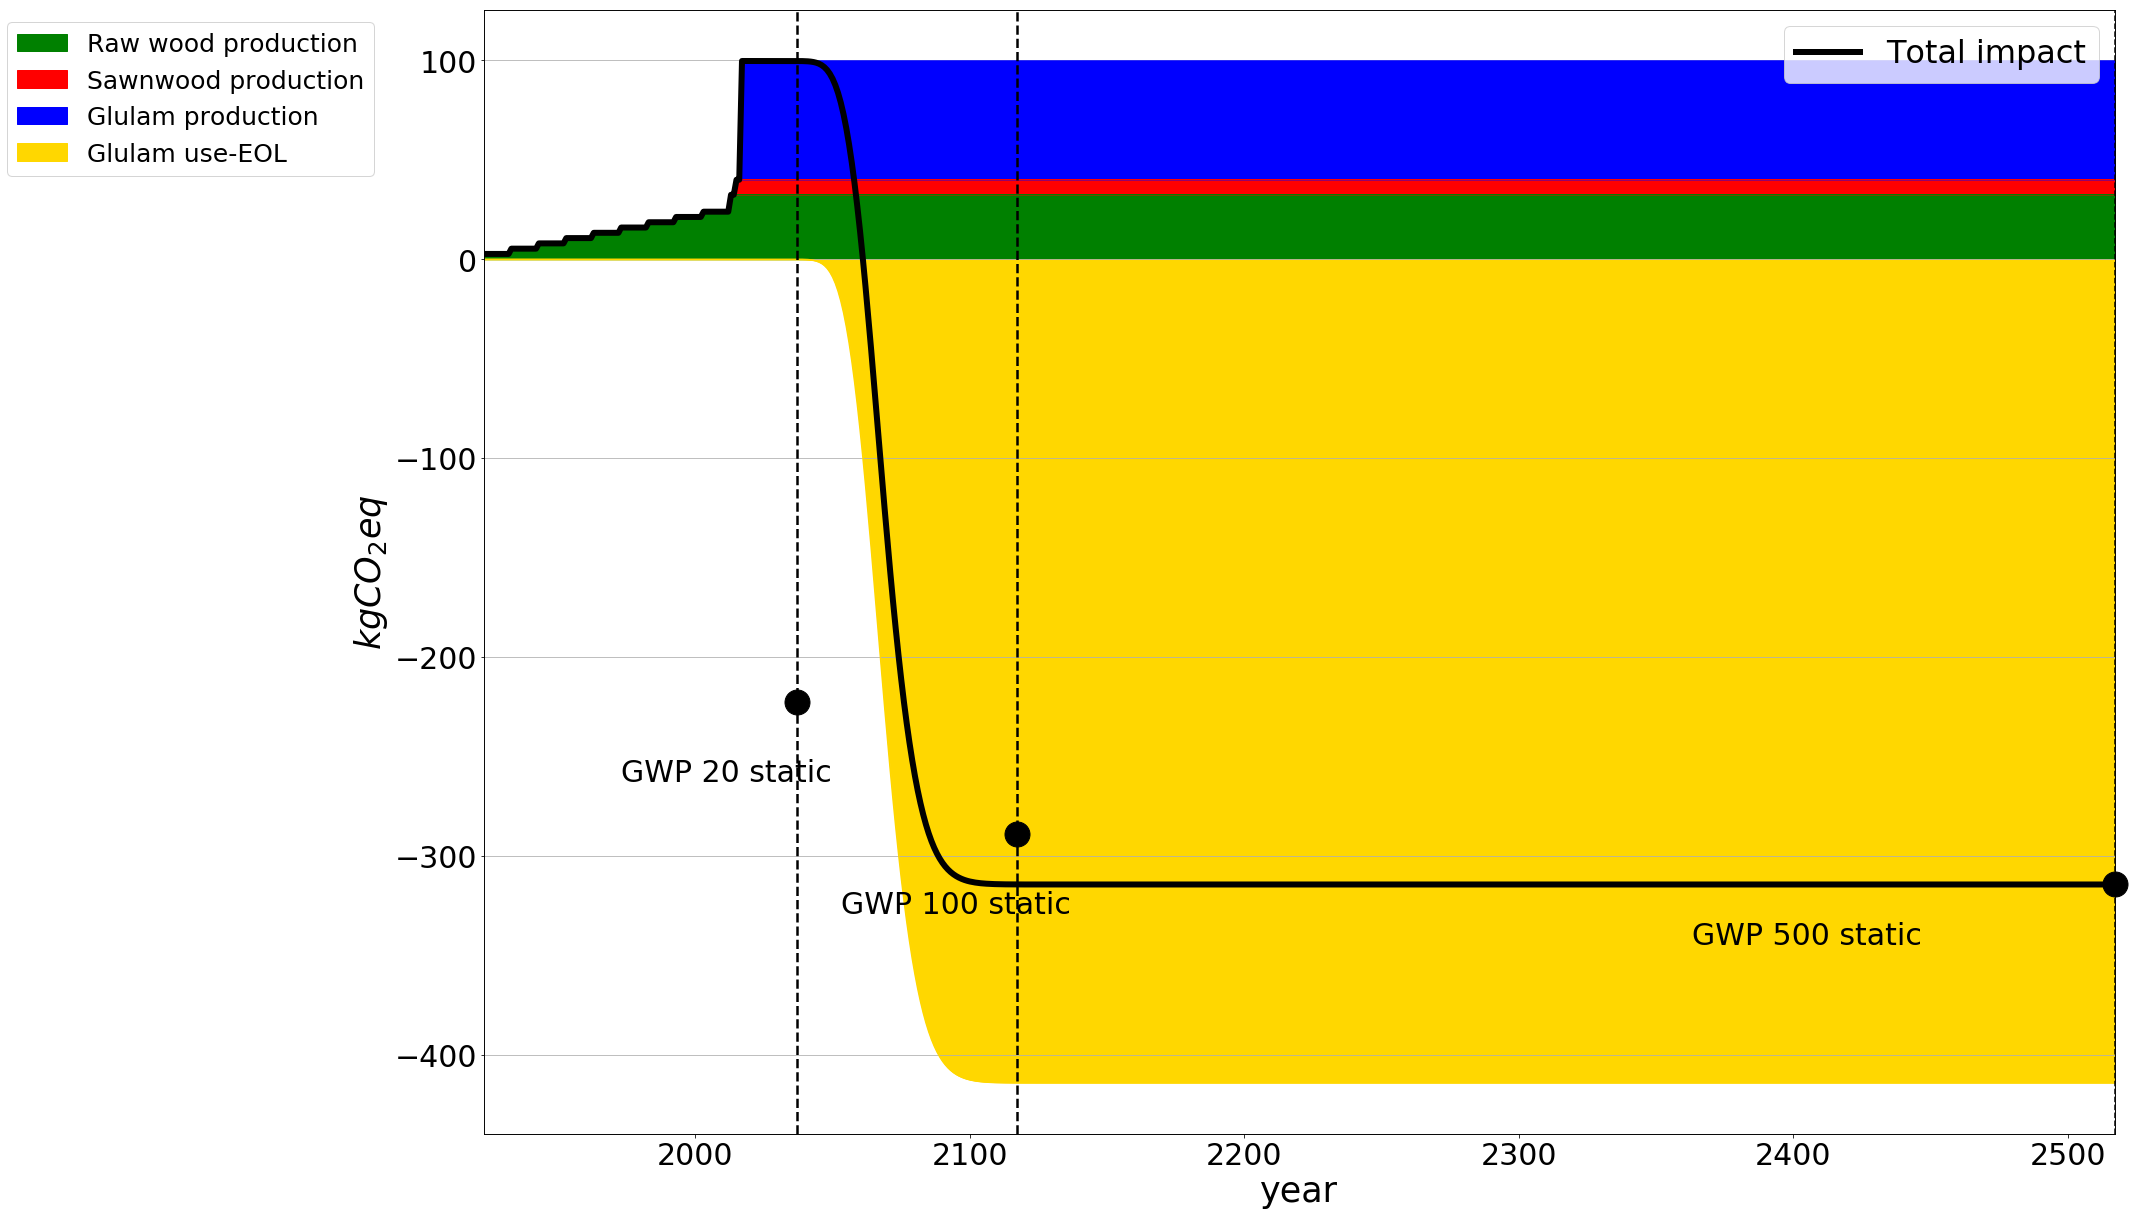

In [13]:
#plot 500 years
size_font=30


fig, ax = plt.subplots(figsize=(11.69*2.5,8.27*2.5))#(33,18))
ax2 = ax.twiny() #needed when overlaying barplot, see https://stackoverflow.com/a/24237358/4929813


#plot
df_st_CF.plot.area(stacked=True,legend=False,fontsize=size_font,ax=ax,color=[colors[i] for i in df_st_CF.columns])#,colormap='Set3') #this is correct
tot_st.plot(linestyle='-', linewidth=6,color='black',legend=False,fontsize=size_font)

#show horizontal grids
ax.grid(True,axis='y')

#adjsut legend
#correct
ax.legend(bbox_to_anchor=(-0.3, 1),fontsize=size_font-5, loc='upper left', ncol=1) #put it outside the graph
ax2.legend(["Total impact"],fontsize=size_font+2,loc='upper right')


#x-ylabel
ax.set_ylabel('$kg CO_2eq$',fontsize=size_font+5)
ax.set_xlabel('year',fontsize=size_font+5)

#remove extra ticks
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)


#####ADD STATIC RESULTS

#calculate static lca for each time horizon (used in plot below)
FU={('tempo', 'glulam_FU'): 1}
all_meth={20:('IPCC 2007', 'climate change', 'GWP 20a'),
          100:('IPCC 2007', 'climate change', 'GWP 100a'),
          500:('IPCC 2007', 'climate change', 'GWP 500a')}
res={}
for yr,m in all_meth.items():
    l = LCA(FU, m)
    l.lci()
    l.lcia()
    res[yr]=l.score 

#draw vertical lines ad circles
line = ax2.lines[0] 
zero=line.get_xdata()[0]
xcoords = [zero+20,zero+100,zero+500]
    
#this starting from 2017
for xc in xcoords:
    if xc-zero==500: #move everything a bit more on the left
        ax2.axvline(x=xc-zero+2017,linewidth=1.5, color = 'k', linestyle='--') #lines
        ax2.plot([xc-zero+2017], [res[xc-zero]], 'k.', markersize=50.0,clip_on=False) #circles
        ax2.annotate('GWP {} static'.format(xc-zero),
                 xy=(xc-60 if (xc-zero)==500 else xc-10, res[xc-zero]-30 ), 
                 size=size_font)
    else:
        ax2.axvline(x=xc-zero+2017,linewidth=2.5, color = 'k', linestyle='--') #lines
        ax2.plot([xc-zero+2017], [res[xc-zero]], 'k.', markersize=50.0,clip_on=False) #circles
        ax2.annotate('GWP {} static'.format(xc-zero),
                 xy=(xc-60 if (xc-zero)==500 else xc+30, res[xc-zero]-40 ), 
                 size=size_font
                )




# # need to put this before show otherwise return blank fig see https://stackoverflow.com/a/21884187/4929813
# # #for paper
# plt.savefig('/media/giuseppec/25F62A4E5FEED162/work/papers/temporalis_paper/pictures/results_st.eps', format='eps',dpi=300,bbox_inches='tight')
# plt.savefig('/media/giuseppec/25F62A4E5FEED162/work/papers/temporalis_paper/pictures/results_st.svg', format='svg',dpi=300,bbox_inches='tight')
# plt.savefig('/media/giuseppec/25F62A4E5FEED162/work/papers/temporalis_paper/pictures/results_st.png', format='png',dpi=500,bbox_inches='tight')

plt.show()


# dynamic LCI dynamic LCIA

In [14]:
fu={('tempo', 'glulam_FU'): 1}

dynlca = DynamicLCA(fu, ('RadiativeForcing','worst case'),t0=np.datetime64('2017-01-01'),cutoff=0.00000001,loop_cutoff=10,group=True)
time_dyn=dynlca.calculate()

In [15]:
#calculate total radiative forcing
yr,resul=time_dyn.characterize_dynamic('RadiativeForcing',cumulative=True,bio_st_decay='chi2',
                                       bio_st_emis_yr=50,rot_stand=130) #with gamma dist, 50 yrs lifetime and 130 yrs rotation




In [16]:
#create dict with results by process

dyn_CF={}
for pr in time_dyn.processes():
    yr_pr_dyn,res_pr_dyn=time_dyn.timeline_for_activity(pr).characterize_dynamic('RadiativeForcing',cumulative=True,bio_st_decay='chi2',
                                                                                 bio_st_emis_yr=50,rot_stand=130) #with gamma dist, 50 yrs lifetime and 130 yrs rotation
#                                                                                  bio_st_emis_yr=150,rot_stand=50) # just a test with different values

    
    dyn_CF[get_activity(pr)['name']]=[yr_pr_dyn,res_pr_dyn]

In [17]:
#convert dict with results to dataframe
df_dyn_CF=pd.DataFrame({k:pd.Series(v[1], index=v[0]) for (k,v) in dyn_CF.items() if len(v[0])>0})
df_dyn_CF.index=df_dyn_CF.index.map(int)#to have int in x axis


In [18]:
#calculate co2 integral and divide everything by it to calculate gwp

df_dyn_CF=df_dyn_CF.loc[:2017+500]#correct

df_dyn_CF['co2']=co2_rf_td.values[:lenght].cumsum() #check if this or one before df_dyn_CF=df_dyn_CF[:501] #correcrt

cum_co2=df_dyn_CF['co2'] #needed below to subtract biogenic carbon

df_dyn_CF=df_dyn_CF.iloc[:,:-1].div(df_dyn_CF.co2, axis=0) #calculate gwp and delete col with gwp of co2
#calculate tot
tot=df_dyn_CF.sum(axis=1)#.sum()

#calculate total impact without biogenic carbon
#calc biogenic impact
yr_bio_dyn,res_bio_dyn=time_dyn.timeline_for_flow(('static_forest','C_biogenic')).characterize_dynamic('RadiativeForcing',cumulative=True,bio_st_decay='chi2',
                                       bio_st_emis_yr=50,rot_stand=130) #with gamma dist, 50 yrs lifetime and 130 yrs rotation
df_bio=pd.Series(res_bio_dyn, index=yr_bio_dyn)
df_bio.index=df_bio.index.map(int)#to have int in x axis

#calculate gpw biogenic
df_bio=df_bio.loc[:2017+500]#correct
impact_bio=df_bio.div(cum_co2)
# subtract to tot
tot_no_bio=tot-impact_bio

In [19]:
#calculate tot
tot=df_dyn_CF.sum(axis=1)#.sum()

In [20]:
#check year when impacts are zero
delay=145
tot.loc[2017+delay-1:2017+delay]


2161   -0.932837
2162   -2.660977
dtype: float64

In [21]:
#cumulative impact over 500 years
df_dyn_CF[-1:].sum().sum()

-205.32854696155218

In [22]:
#rename columns
df_dyn_CF.rename(columns=names_cols ,inplace=True)

#merge duplicate columns
df_dyn_CF=df_dyn_CF.T.groupby(df_dyn_CF.T.index).sum().T

#reorder cols to better graph
dyn_cols_order=[]
for index, row in df_dyn_CF.iterrows():
    for x,y in row.iteritems():
        if pd.notnull(y) and x not in dyn_cols_order:
            dyn_cols_order.append(x)

df_dyn_CF = df_dyn_CF[dyn_cols_order]
            

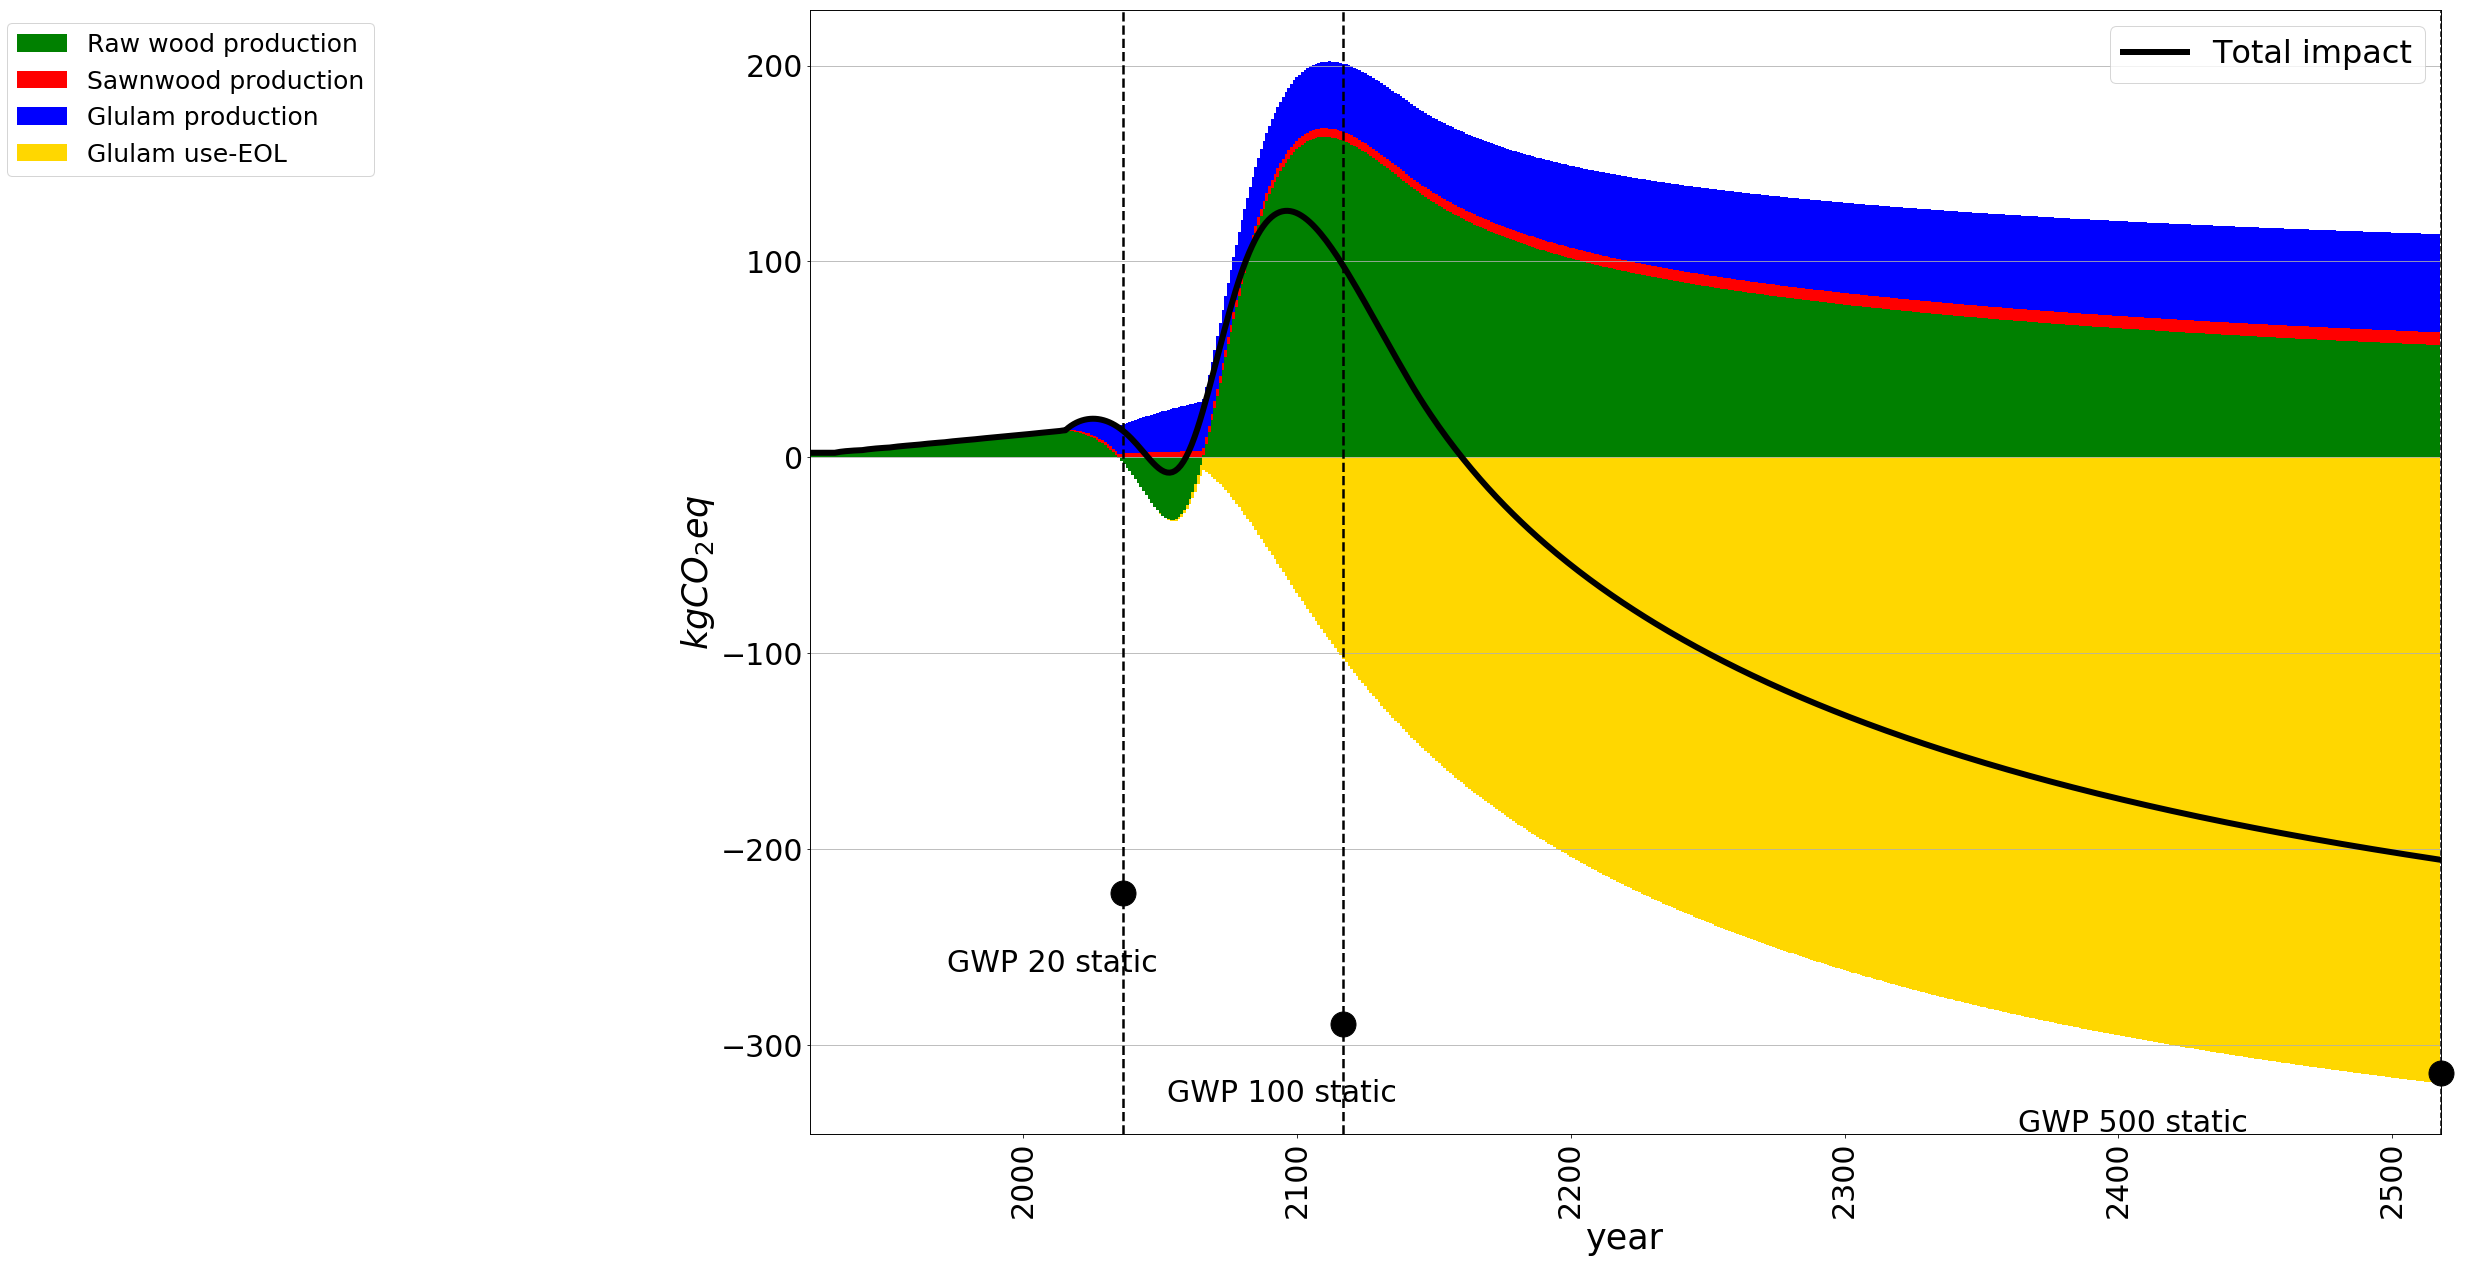

In [23]:
#plot dyn

size_font=30

fig, ax = plt.subplots(figsize=(11.69*2.5,8.27*2.5))#(33,18))
ax2 = ax.twiny() #needed when overlaying barplot, see https://stackoverflow.com/a/24237358/4929813

#to set the number of xticks
# ax.locator_params(axis='x',nbins=10)

#plot
df_dyn_CF.plot(kind='bar',width=1,stacked=True,legend=False,fontsize=size_font,ax=ax,color=[colors[i] for i in df_dyn_CF.columns])#,colormap='Paired') #this is correct
tot.plot(linestyle='-', linewidth=6,color='black',legend=False,fontsize=size_font)

# # # adjust xticks number of ticks (not needed with plot.area, only with bar)
n = 100
ticks = ax.xaxis.get_ticklocs()
ticklabels = [l.get_text() for l in ax.xaxis.get_ticklabels()]
ax.xaxis.set_ticks(ticks[::n]+77)
ax.xaxis.set_ticklabels(ticklabels[77::n])


#show horizontal grids
ax.grid(True,axis='y')

#adjsut legend
ax.legend(bbox_to_anchor=(-0.5, 1),fontsize=size_font-5, loc='upper left', ncol=1) #put it outside the graph
ax2.legend(["Total impact"],fontsize=size_font+2,loc='upper right')


#x-ylabel
ax.set_ylabel('$kg CO_2eq$',fontsize=size_font+5)
ax.set_xlabel('year',fontsize=size_font+5)

#remove extra ticks
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)


######ADD STATIC RESULTS

#calculate static lca for each time horizon (used in plot below)
FU={('tempo', 'glulam_FU'): 1}
all_meth={20:('IPCC 2007', 'climate change', 'GWP 20a'),
          100:('IPCC 2007', 'climate change', 'GWP 100a'),
          500:('IPCC 2007', 'climate change', 'GWP 500a')}
res={}
for yr,m in all_meth.items():
    l = LCA(FU, m)
    l.lci()
    l.lcia()
    res[yr]=l.score 

#draw vertical lines ad circles
line = ax2.lines[0] 
zero=line.get_xdata()[0]
xcoords = [zero+20,zero+100,zero+500]
    
#this starting from 2017
for xc in xcoords:
    if xc-zero==500: #move everything a bit more on the left
        ax2.axvline(x=xc-zero+2017,linewidth=1.5, color = 'k', linestyle='--') #lines
        ax2.plot([xc-zero+2017], [res[xc-zero]], 'k.', markersize=50.0,clip_on=False) #circles
        ax2.annotate('GWP {} static'.format(xc-zero),
                 xy=(xc-60 if (xc-zero)==500 else xc-10, res[xc-zero]-30 ), 
                 size=size_font)
    else:
        ax2.axvline(x=xc-zero+2017,linewidth=2.5, color = 'k', linestyle='--') #lines
        ax2.plot([xc-zero+2017], [res[xc-zero]], 'k.', markersize=50.0,clip_on=False) #circles
        ax2.annotate('GWP {} static'.format(xc-zero),
                 xy=(xc-60 if (xc-zero)==500 else xc+30, res[xc-zero]-40 ), 
                 size=size_font
                )

# need to put this before show otherwise return blank fig see https://stackoverflow.com/a/21884187/4929813
#for paper
# plt.savefig('/media/giuseppec/25F62A4E5FEED162/work/papers/temporalis_paper/pictures/results.eps', format='eps',dpi=300,bbox_inches='tight')
# plt.savefig('/media/giuseppec/25F62A4E5FEED162/work/papers/temporalis_paper/pictures/results.svg', format='svg',dpi=300,bbox_inches='tight')
# plt.savefig('/media/giuseppec/25F62A4E5FEED162/work/papers/temporalis_paper/pictures/results.png', format='png',dpi=500,bbox_inches='tight')


plt.show()


# instantaneous emissions

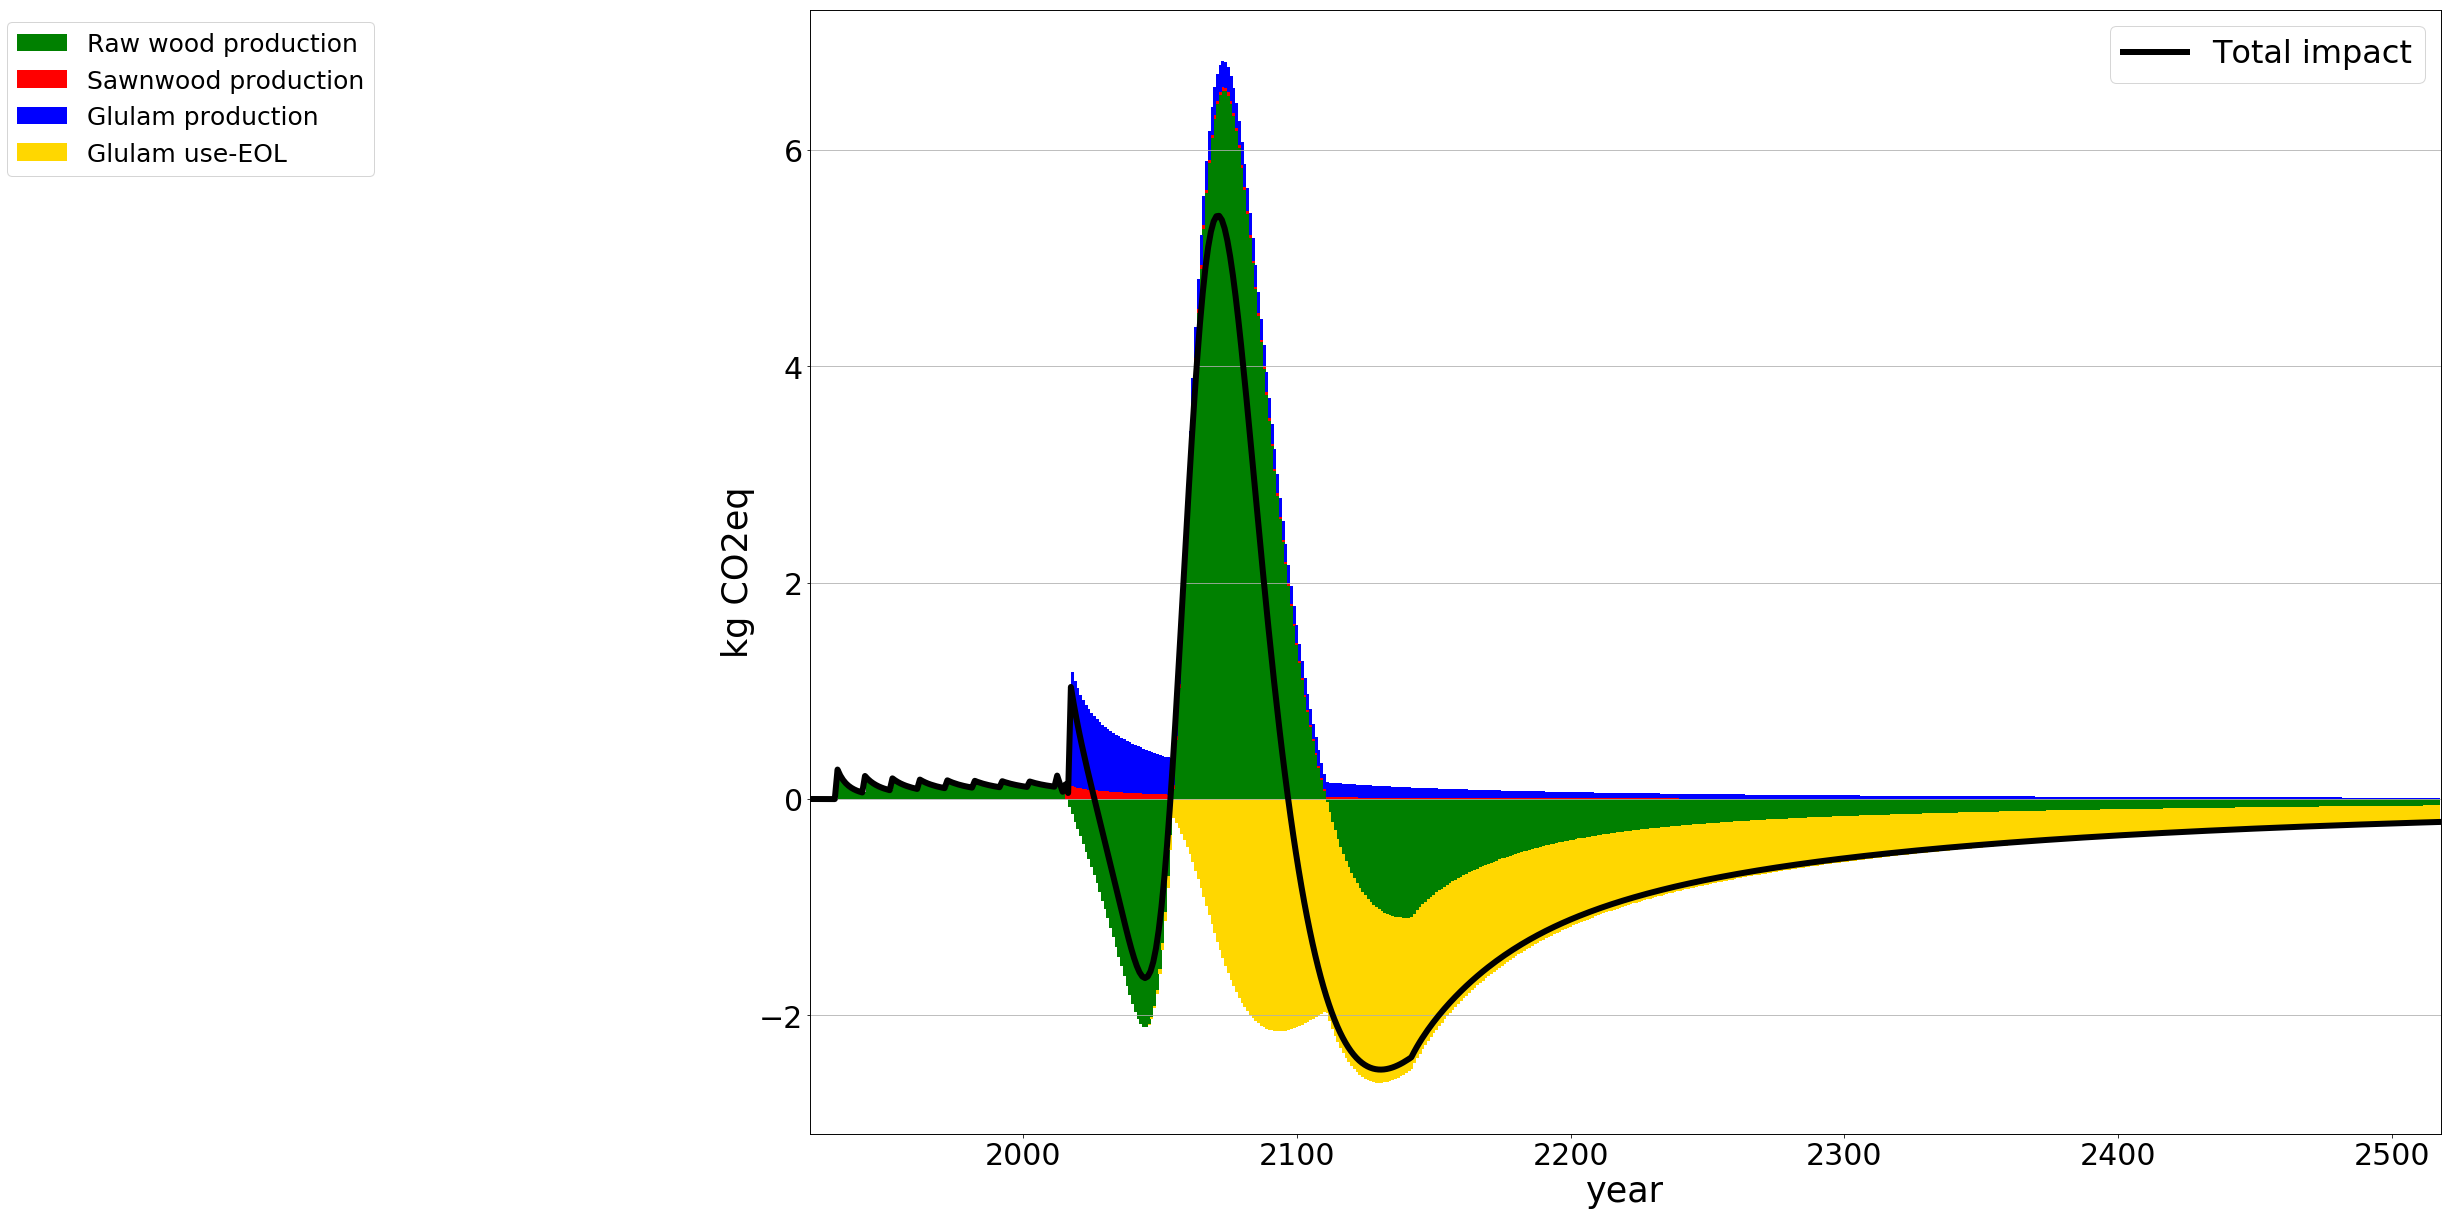

In [24]:
#test: plot non cumulative

df_non_cum=df_dyn_CF.diff(axis=0)
tot_non_cum=df_non_cum.sum(axis=1)#.sum()



size_font=30


fig, ax = plt.subplots(figsize=(11.69*2.5,8.27*2.5))#(33,18))
ax2 = ax.twiny() #needed when overlaying barplot, see https://stackoverflow.com/a/24237358/4929813

# df_non_cum.iloc[:5,:-1].plot(kind='bar',stacked=True,legend=False,width=1,fontsize=18,ax=ax)
# tot_non_cum[:5].plot(linestyle='-', linewidth=6,color='black',legend=True)

df_non_cum.plot(kind='bar',stacked=True,legend=False,width=1.1,fontsize=size_font,ax=ax,color=[colors[i] for i in df_non_cum.columns])#,colormap='Paired')
tot_non_cum.plot(linestyle='-', linewidth=6,color='black',legend=False,fontsize=size_font)

# # adjust xticks number of ticks (not needed with plot.area, only with bar)
n = 100
ticks = ax.xaxis.get_ticklocs()
ticklabels = [l.get_text() for l in ax.xaxis.get_ticklabels()]
ax.xaxis.set_ticks(ticks[::n]+77)
ax.xaxis.set_ticklabels(ticklabels[77::n], rotation=0)

#show horizontal grids
ax.grid(True,axis='y')

#adjsut legend
#correct
ax.legend(bbox_to_anchor=(-0.5, 1),fontsize=size_font-5, loc='upper left', ncol=1) #put it outside the graph
ax2.legend(["Total impact"],fontsize=size_font+2,loc='upper right')
#not correct
# ax.legend(ax.get_legend_handles_labels()[1]+['Total impact'],#add total impact to legend, does not work
# ax.legend(ncol=2,fontsize=16,loc='lower left', framealpha=0) framealpha=0 make transparent


#x-ylabel
ax.set_ylabel('kg CO2eq',fontsize=size_font+5)
ax.set_xlabel('year',fontsize=size_font+5)

#remove extra ticks
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)


plt.show()


## merge two graphs


## merge four graphs for paper


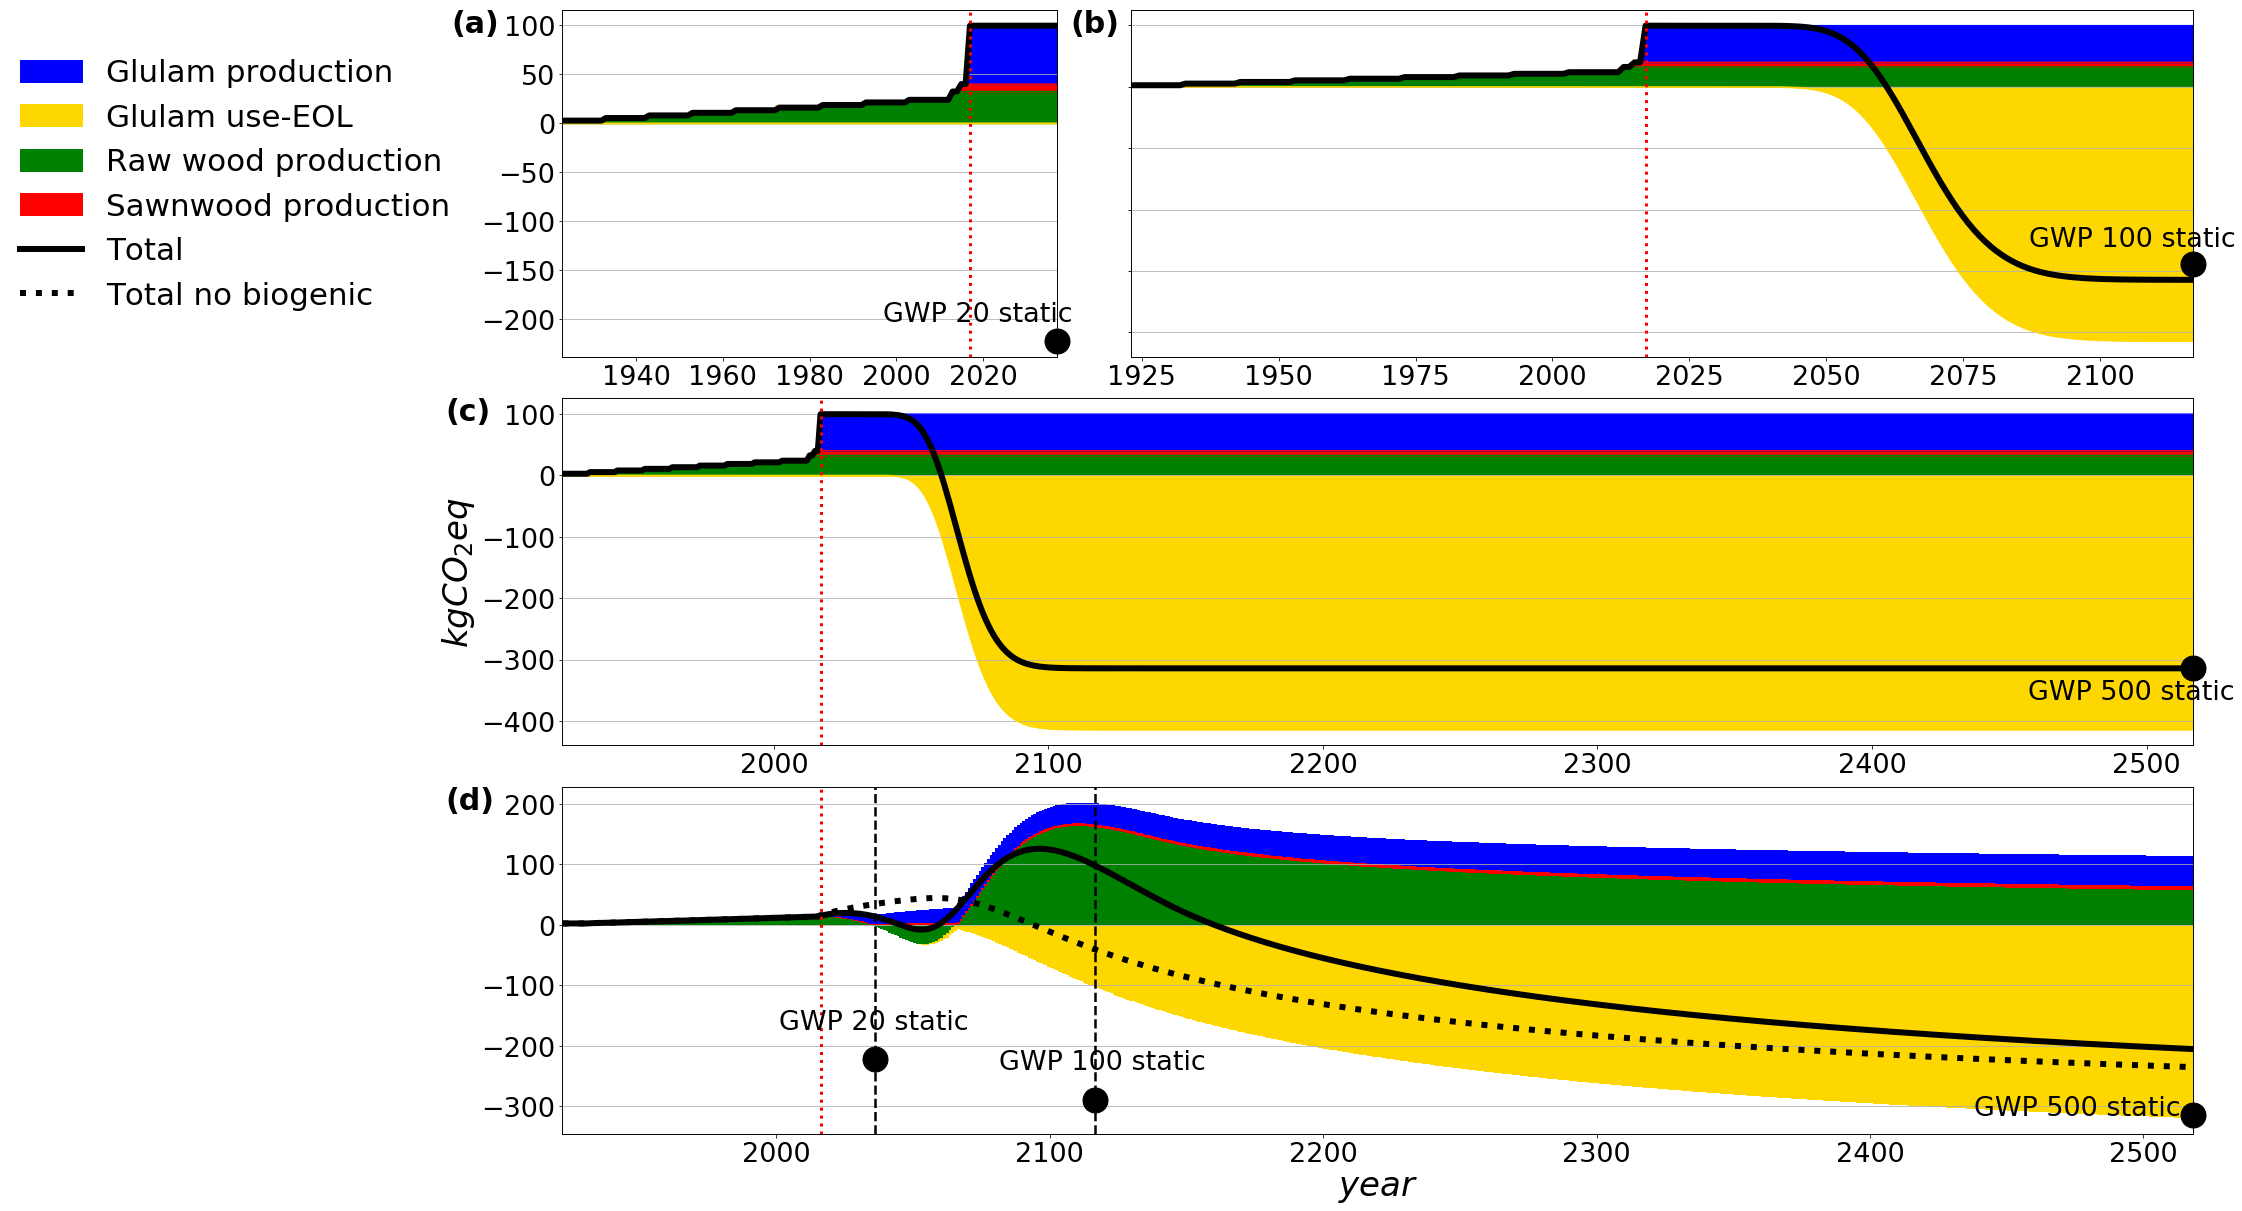

In [25]:
#plot for paper
size_font=27


# #to make everything bold see https://stackoverflow.com/a/43111170/4929813
plt.rcParams["font.weight"] = "medium"
plt.rcParams["axes.labelweight"] = "medium"

#make canvas

fig = plt.figure(figsize=(11.69*2.5,8.27*2.5)) #a4
# fig = plt.figure(figsize=(11.69*2,8.27*2.5)) #narrower

ax = plt.subplot(2, 2, 1)


ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=1)
ax3 = plt.subplot2grid((3, 3), (0, 1), colspan=2)
ax5 = plt.subplot2grid((3, 3), (1, 0), colspan=3)
ax7 = plt.subplot2grid((3, 3), (2, 0), colspan=3)

###############GRAPH 20############

ax2 = ax1.twiny() #needed when overlaying barplot, see https://stackoverflow.com/a/24237358/4929813


#plot
df_st_CF.loc[:2017+20].plot.area(stacked=True,legend=False,fontsize=size_font,ax=ax1,color=[colors[i] for i in df_st_CF.columns])#,colormap='Set3') #this is correct
tot_st.iloc[:len(df_st_CF.loc[:2017+20])].plot(linestyle='-', linewidth=6,color='black',legend=False,fontsize=size_font)

#show horizontal grids
ax1.grid(True,axis='y')

#remove extra ticks
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)

#to set the number of xticks (untill part above not fixed)
ax2.locator_params(axis='x',nbins=10)


#ADD STATIC RESULTS

FU={('tempo', 'glulam_FU'): 1}
all_meth={20:('IPCC 2007', 'climate change', 'GWP 20a')
         }
res={}
for yr,m in all_meth.items():
    l = LCA(FU, m)
    l.lci()
    l.lcia()
    res[yr]=l.score 

#draw vertical lines ad circles
zero=2017
xcoords = [zero+20]
    
#this starting from 2017
for xc in xcoords:
    ax2.plot([xc-zero+2017], [res[xc-zero]], 'k.', markersize=50.0,clip_on=False) #circles
    ax2.annotate('GWP {} static'.format(xc-zero),
             xy=(xc-40, res[xc-zero]+20), 

             size=size_font
            )
    
#add t0
ax2.axvline(2017,linewidth=3, color = 'r', linestyle=':') #lines

#####GRPH 100###########

ax4 = ax3.twiny() #needed when overlaying barplot, see https://stackoverflow.com/a/24237358/4929813


#plot
df_st_CF.loc[:2017+100].plot.area(stacked=True,legend=False,fontsize=size_font,ax=ax3,color=[colors[i] for i in df_st_CF.columns])#,colormap='Set3') #this is correct
tot_st.iloc[:len(df_st_CF.loc[:2017+100])].plot(linestyle='-', linewidth=6,color='black',legend=False,fontsize=size_font)

#show horizontal grids
ax3.grid(True,axis='y')

#remove extra ticks
ax4.get_xaxis().set_visible(False)
ax4.get_yaxis().set_visible(False)


#####ADD STATIC RESULTS

FU={('tempo', 'glulam_FU'): 1}
all_meth={100:('IPCC 2007', 'climate change', 'GWP 100a'),

         }
res={}
for yr,m in all_meth.items():
    l = LCA(FU, m)
    l.lci()
    l.lcia()
    res[yr]=l.score 

#draw vertical lines ad circles
zero=2017
xcoords = [zero+100]
    
#this starting from 2017
for xc in xcoords:
        ax4.plot([xc-zero+2017], [res[xc-zero]], 'k.', markersize=50.0,clip_on=False) #circles
        ax4.annotate('GWP {} static'.format(xc-zero),
#                  xy=(xc+60, res[xc-zero]+30 ), 
                 xy=(xc-30, res[xc-zero]+30 ), 

                 size=size_font
                )

#add t0
ax4.axvline(2017,linewidth=3, color = 'r', linestyle=':') #lines

#####GRAPH 500#########

ax6 = ax5.twiny() #needed when overlaying barplot, see https://stackoverflow.com/a/24237358/4929813

#plot
df_st_CF.plot.area(stacked=True,legend=False,fontsize=size_font,ax=ax5,color=[colors[i] for i in df_st_CF.columns])#,colormap='Set3') #this is correct
tot_st.plot(linestyle='-', linewidth=6,color='black',legend=False,fontsize=size_font)

#show horizontal grids
ax5.grid(True,axis='y')

#x-ylabel
ax5.set_ylabel('$kg CO_2eq$',fontsize=size_font+7)

#remove extra ticks
ax6.get_xaxis().set_visible(False)
ax6.get_yaxis().set_visible(False)


#####ADD STATIC RESULTS

#calculate static lca for each time horizon (used in plot below)
FU={('tempo', 'glulam_FU'): 1}
all_meth={500:('IPCC 2007', 'climate change', 'GWP 500a')
         }
res={}
for yr,m in all_meth.items():
    l = LCA(FU, m)
    l.lci()
    l.lcia()
    res[yr]=l.score 

#draw vertical lines ad circles
zero=2017
xcoords = [zero+500]
    
#this starting from 2017
for xc in xcoords:
    ax6.plot([xc], [res[xc-zero]], 'k.', markersize=50.0,clip_on=False) #circles
    ax6.annotate('GWP {} static'.format(xc-zero),
             xy=(xc-60, res[xc-zero]-50 ), 
             size=size_font)

#add t0
ax6.axvline(2017,linewidth=3, color = 'r', linestyle=':') #lines
        
# ###############GRAPH dynamic###########################

ax8 = ax7.twiny() #needed when overlaying barplot, see https://stackoverflow.com/a/24237358/4929813

#plot
df_dyn_CF.plot(kind='bar',width=2,stacked=True,legend=False,fontsize=size_font,ax=ax7,lw=0,color=[colors[i] for i in df_dyn_CF.columns])#,sharex=ax[0], lw=0,color=[colors[i] for i in df_dyn_CF.columns])
tot.plot(linestyle='-', linewidth=6,color=colors['Total'] ,legend=False,fontsize=size_font)
tot_no_bio.plot(linestyle=':', linewidth=6,color=colors['Total no biogenic'] ,legend=False,fontsize=size_font)


#show horizontal grids
ax7.grid(True,axis='y')

# #adjsut legend
labels=columns 
handles = [plt.Rectangle((0,0),1,1, color=colors[l]) for l in labels[:4]] #[:4] to not take the two totals

line_tots=[plt.Line2D((0,2),(0,0), color='k', linestyle='-',linewidth=6),#line for total
          plt.Line2D((0,2),(0,0), color='k', linestyle=':',linewidth=6)]#line for total wihotu bio

handles+=line_tots

ax8.legend(handles=handles, labels=labels,bbox_to_anchor=(-0.35, 3.18),fontsize=size_font+4, loc='upper left', ncol=1,frameon=False) #put it outside the graph


#x-ylabel
ax7.set_xlabel('$year$',fontsize=size_font+7)

#remove extra ticks
ax8.get_xaxis().set_visible(False)
ax8.get_yaxis().set_visible(False)

       
# # adjust xticks number of ticks (not needed with plot.area, only with bar)
n = 100
ticks = ax7.xaxis.get_ticklocs()
ticklabels = [l.get_text() for l in ax7.xaxis.get_ticklabels()]
ax7.xaxis.set_ticks(ticks[::n]+77)
ax7.xaxis.set_ticklabels(ticklabels[77::n], rotation=0)


######ADD STATIC RESULTS TO DYN GRAPH

#calculate static lca for each time horizon (used in plot below)
FU={('tempo', 'glulam_FU'): 1}
all_meth={20:('IPCC 2007', 'climate change', 'GWP 20a'),
          100:('IPCC 2007', 'climate change', 'GWP 100a'),
          500:('IPCC 2007', 'climate change', 'GWP 500a')}
res={}
for yr,m in all_meth.items():
    l = LCA(FU, m)
    l.lci()
    l.lcia()
    res[yr]=l.score 

#draw vertical lines ad circles
zero=2017
xcoords = [zero+20,zero+100,zero+500]


#stati results
for xc in xcoords:
    if xc-zero==500: #move everything a bit more on the left
        ax8.plot([xc], [res[xc-zero]], 'k.', markersize=50.0,clip_on=False) #circles
        ax8.annotate('GWP {} static'.format(xc-zero),
                 xy=(xc-80 , res[xc-zero] ), 
                 size=size_font)
    else:
        ax8.axvline(x=xc,linewidth=2.5, color = 'k', linestyle='--') #lines
        ax8.plot([xc], [res[xc-zero]], 'k.', markersize=50.0,clip_on=False) #circles
        ax8.annotate('GWP {} static'.format(xc-zero),
                 xy=(xc-35, res[xc-zero]+50 ), 
                 size=size_font
                )
#add t0
ax8.axvline(2017,linewidth=3, color = 'r', linestyle=':') #lines
        
# enumerate suplots
ax1.annotate('(a)', xy=(-.075*3, 1), xycoords='axes fraction', fontsize=size_font+3,  textcoords='offset points',   ha='left', va='top',fontweight='semibold')
ax3.annotate('(b)', xy=(-.057, 1), xycoords='axes fraction', fontsize=size_font+3,  textcoords='offset points',   ha='left', va='top',fontweight='semibold')
ax5.annotate('(c)', xy=(-.072, 1), xycoords='axes fraction', fontsize=size_font+3,  textcoords='offset points',   ha='left', va='top',fontweight='semibold')
ax7.annotate('(d)', xy=(-.072, 1), xycoords='axes fraction', fontsize=size_font+3,  textcoords='offset points',   ha='left', va='top',fontweight='semibold')

#reduce space between graphs
plt.subplots_adjust(wspace=0.15, hspace=0.12)


# need to put this before show otherwise return blank fig see https://stackoverflow.com/a/21884187/4929813
# # #for paper
# plt.savefig('/media/giuseppec/25F62A4E5FEED162/work/papers/temporalis_paper/pictures/results.eps', format='eps',dpi=400,bbox_inches='tight')
# plt.savefig('/media/giuseppec/25F62A4E5FEED162/work/papers/temporalis_paper/pictures/results.svg', format='svg',dpi=400,bbox_inches='tight')
# plt.savefig('/media/giuseppec/25F62A4E5FEED162/work/papers/temporalis_paper/pictures/results.png', format='png',dpi=500,bbox_inches='tight')
# plt.savefig('/media/giuseppec/25F62A4E5FEED162/work/papers/temporalis_paper/pictures/results.pdf', format='pdf',dpi=400,bbox_inches='tight')



plt.show()

# calculate differences in the results

In [26]:
#Relative Percentage Difference  (|Num1-Num2|/((Num1+Num2)/2)) x 100
FU={('tempo', 'glulam_FU'): 1}
all_meth=list(zip([20,100,500],[('IPCC 2007', 'climate change', 'GWP 20a'),('IPCC 2007', 'climate change', 'GWP 100a'),('IPCC 2007', 'climate change', 'GWP 500a')]))

res={}
for yr,m in all_meth:
    l = LCA(FU, m)
    l.lci()
    l.lcia()
    st_res=l.score 
    print("OVER {} YEAR".format(yr))
    print("Relative Percentage Difference between the static and fully dynamic over {}: ".format(yr), abs(round((abs(st_res-tot.loc[2017+yr])/((st_res+tot.loc[2017+yr])/2))*100,2))) #reference st
    print("Relative Percentage Difference between the static and fully dynamic without biogenic over {}: ".format(yr), abs(round((abs(st_res-tot_no_bio.loc[2017+yr])/((st_res+tot_no_bio.loc[2017+yr])/2))*100,2))) #reference st
    print()
    print()

OVER 20 YEAR
Relative Percentage Difference between the static and fully dynamic over 20:  226.01
Relative Percentage Difference between the static and fully dynamic without biogenic over 20:  273.86


OVER 100 YEAR
Relative Percentage Difference between the static and fully dynamic over 100:  406.11
Relative Percentage Difference between the static and fully dynamic without biogenic over 100:  150.66


OVER 500 YEAR
Relative Percentage Difference between the static and fully dynamic over 500:  41.92
Relative Percentage Difference between the static and fully dynamic without biogenic over 500:  28.78




In [28]:
print( '0 impact:' ,tot[(tot >= -1) & (tot <= 1)].index[0] - 2017)


0 impact: 29


# sensitivity analysis of time parameters

IMPACT
for lifetime: 1 and rotation : 50 graph: a  20 years: 348.748158884 100 years: 54.0856765532 500 years: 2517   -305.373933
dtype: float64 

0 impact 119
for lifetime: 50 and rotation : 50 graph: b  20 years: -71.2132340664 100 years: -281.730572242 500 years: 2517   -301.801443
dtype: float64 

0 impact 9
for lifetime: 150 and rotation : 50 graph: c  20 years: -71.2708812973 100 years: -901.883819024 500 years: 2517   -545.589524
dtype: float64 

0 impact 9
for lifetime: 1 and rotation : 130 graph: d  20 years: 433.54437546 100 years: 434.056030261 500 years: 2517   -208.901037
dtype: float64 

0 impact 244
for lifetime: 50 and rotation : 130 graph: e  20 years: 13.5829825098 100 years: 98.2397814658 500 years: 2517   -205.328547
dtype: float64 

0 impact 28
for lifetime: 150 and rotation : 130 graph: f  20 years: 13.525335279 100 years: -521.913465316 500 years: 2517   -449.116628
dtype: float64 

0 impact 28
for lifetime: 1 and rotation : 200 graph: g  20 years: 443.214283521 

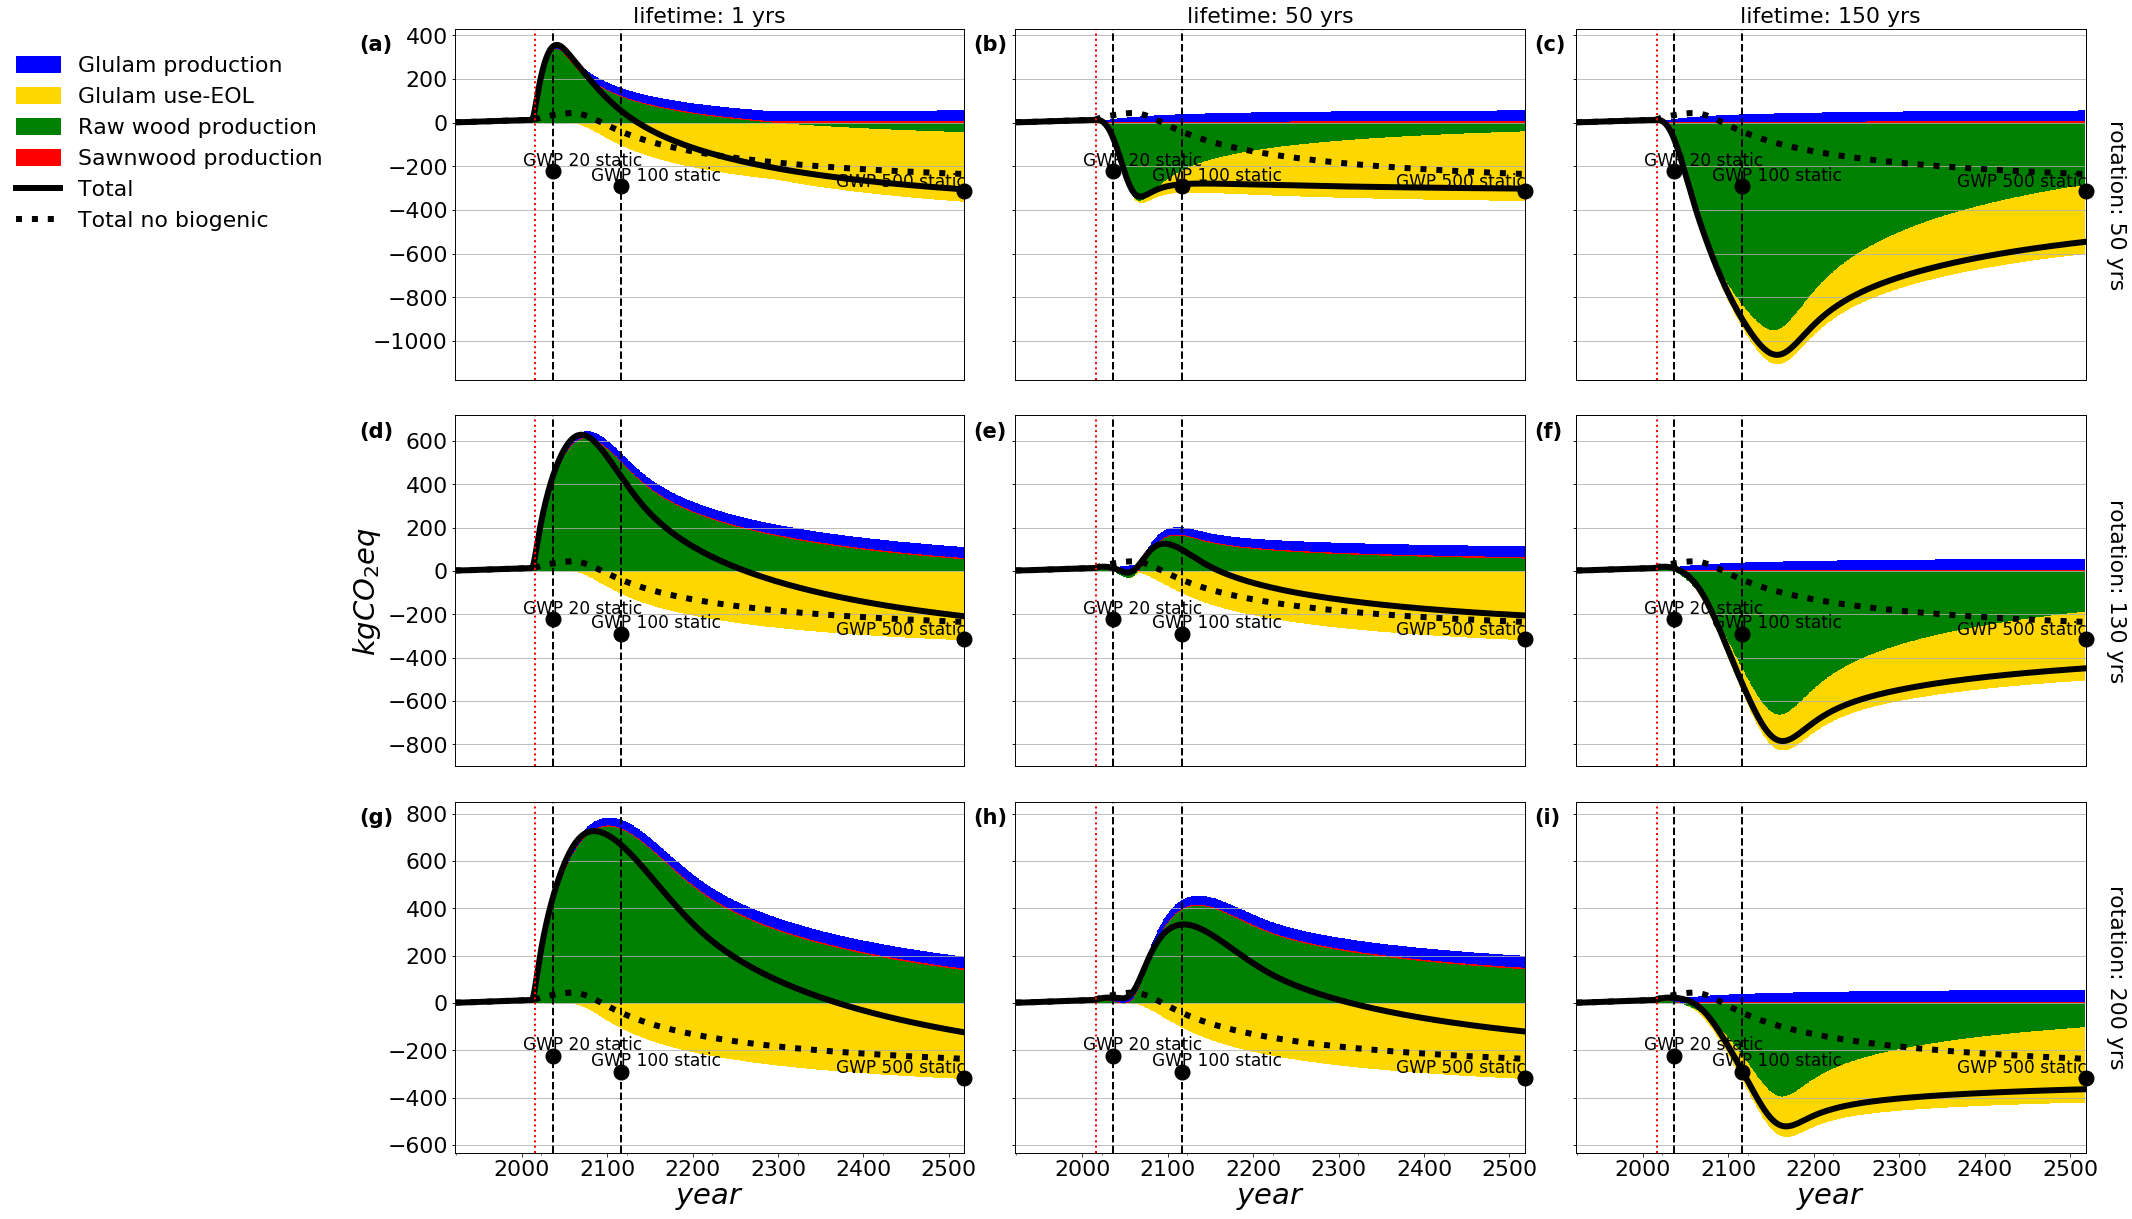

In [34]:
#plot for paper
size_font=22


# #to make everything bold see https://stackoverflow.com/a/43111170/4929813
plt.rcParams["font.weight"] = "medium"
plt.rcParams["axes.labelweight"] = "medium"

#make canvas

# fig, axs = plt.subplots(9,1, figsize=(11.69,8.27*4))#, facecolor='w', edgecolor='k') # A TEST TO DEL

fig, axs = plt.subplots(3,3, figsize=(11.69*2.5,8.27*2.5),sharex='col', sharey='row')#, facecolor='w', edgecolor='k')
# fig, axs = plt.subplots(2,2, figsize=(11.69*2.5,8.27*2.5),sharex='col', sharey='row')#, facecolor='w', edgecolor='k') # ust a test for 4 graphs

axs = axs.ravel()


#calculate static lca for each time horizon (used in plot below)
FU={('tempo', 'glulam_FU'): 1}
all_meth={20:('IPCC 2007', 'climate change', 'GWP 20a'),
          100:('IPCC 2007', 'climate change', 'GWP 100a'),
          500:('IPCC 2007', 'climate change', 'GWP 500a')}
res={}
for yr,m in all_meth.items():
    l = LCA(FU, m)
    l.lci()
    l.lcia()
    res[yr]=l.score 

#draw vertical lines ad circles
zero=2017
xcoords = [zero+20,zero+100,zero+500]


#solve lca before to save time and avoid repeating it every time
fu={('tempo', 'glulam_FU'): 1}
dynlca = DynamicLCA(fu, ('RadiativeForcing','worst case'),t0=np.datetime64('2017-01-01'),cutoff=0.00000001,loop_cutoff=10,group=True)
time_dyn=dynlca.calculate()

print('IMPACT')

for ind, (rot, life) in enumerate(zip([50]*3+[130]*3+[200]*3,[1,50,150]*3)):
# for ind, (rot, life) in enumerate(zip([50]*2+[130]*2,[1,50,150]*2)): # just a test for 4 graphs
    
    #create dict with results by process
    dyn_CF={}
    for pr in time_dyn.processes():
        yr_pr_dyn,res_pr_dyn=time_dyn.timeline_for_activity(pr).characterize_dynamic(
                                    'RadiativeForcing',cumulative=True,bio_st_decay='chi2',bio_st_emis_yr=life,rot_stand=rot) #with gamma dist, lifetime and rotation
        dyn_CF[get_activity(pr)['name']]=[yr_pr_dyn,res_pr_dyn]

    #convert dict with results to dataframe
    df_dyn_CF=pd.DataFrame({k:pd.Series(v[1], index=v[0]) for (k,v) in dyn_CF.items() if len(v[0])>0})
    df_dyn_CF.index=df_dyn_CF.index.map(int)#to have int in x axis


    #clauclate co2 integral and divide everything by it to calculate gwp
    df_dyn_CF=df_dyn_CF.loc[:2017+500] #correct
    df_dyn_CF['co2']=co2_rf_td.values[:lenght].cumsum() #check if this or one before df_dyn_CF=df_dyn_CF[:501] #correcrt
    cum_co2=df_dyn_CF['co2'] #needed below to subtract biogenic carbon
    df_dyn_CF=df_dyn_CF.iloc[:,:-1].div(df_dyn_CF.co2, axis=0) #calculate gwp and delete col with gwp of co2
    
    #calculate tot
    tot=df_dyn_CF.sum(axis=1)#.sum()
    
    #calculate total impact without biogenic carbon
    #calc biogenic impact
    yr_bio_dyn,res_bio_dyn=time_dyn.timeline_for_flow(('static_forest','C_biogenic')).characterize_dynamic(
                                    'RadiativeForcing',cumulative=True,bio_st_decay='chi2',bio_st_emis_yr=life,rot_stand=rot) #with gamma dist, lifetime and rotation
    
    df_bio=pd.Series(res_bio_dyn, index=yr_bio_dyn)
    df_bio.index=df_bio.index.map(int)#to have int in x axis

    #calculate gpw biogenic
    df_bio=df_bio.loc[:2017+500]#correct
    impact_bio=df_bio.div(cum_co2)
    # subtract to tot
    tot_no_bio=tot-impact_bio


    #rename columns
    df_dyn_CF.rename(columns=names_cols ,inplace=True)

    #merge duplicate columns
    df_dyn_CF=df_dyn_CF.T.groupby(df_dyn_CF.T.index).sum().T

    #reorder cols to better graph
    dyn_cols_order=[]
    for index, row in df_dyn_CF.iterrows():
        for x,y in row.iteritems():
            if pd.notnull(y) and x not in dyn_cols_order:
                dyn_cols_order.append(x)

    df_dyn_CF = df_dyn_CF[dyn_cols_order]
    
    
    #plot
    ax1 = axs[ind].twiny()#needed when overlaying barplot, see https://stackoverflow.com/a/24237358/4929813  ,added twinx to have shareed ticks

    df_dyn_CF.plot(kind='bar',width=2,stacked=True,legend=False,fontsize=size_font,ax=axs[ind],lw=0,color=[colors[i] for i in df_dyn_CF.columns])#, lw=0,color=[colors[i] for i in df_dyn_CF.columns])
    tot.plot(linestyle='-', linewidth=6,color=colors['Total'] ,legend=False,fontsize=size_font,ax=ax1)
    tot_no_bio.plot(linestyle=':', linewidth=6,color=colors['Total no biogenic'] ,legend=False,fontsize=size_font,ax=ax1)

    #show horizontal grids
    axs[ind].grid(True,axis='y')

    #x-ylabel
    axs[ind].set_xlabel('$year$',fontsize=size_font+7)

    #remove xticks to make shared axes 
    if ind in [0,1,2,3,4,5]:
        axs[ind].get_xaxis().set_visible(False)
    
    #remove extra ticks above
    ax1.get_xaxis().set_visible(False)
    ax1.get_yaxis().set_visible(False)


    # # adjust xticks number of ticks (not needed with plot.area, only with bar)
    n = 100
    ticks = axs[ind].xaxis.get_ticklocs()
    ticklabels = [l.get_text() for l in axs[ind].xaxis.get_ticklabels()]
    axs[ind].xaxis.set_ticks(ticks[::n]+77)
    axs[ind].xaxis.set_ticklabels(ticklabels[77::n], rotation=0)

    #add lifetime and rotation 
    if ind in [0,1,2]:
        axs[ind].set_title("lifetime: {} yrs".format(life),fontsize=size_font)

    if ind in [2,5,8]:
        ax2 = axs[ind].twinx()
        ax2.set_ylabel("rotation: {} yrs".format(rot),fontsize=size_font,rotation=270, labelpad=40)
        ax2.set_yticks([]) 

    ######ADD STATIC RESULTS TO DYN GRAPH
    for xc in xcoords:
        if xc-zero==500: #move everything a bit more on the left
            ax1.plot([xc], [res[xc-zero]], 'k.', markersize=30,clip_on=False) #circles
            ax1.annotate('GWP {} static'.format(xc-zero),
                     xy=(xc-150 , res[xc-zero]+20 ), 
                     size=size_font-5)
        else:
            ax1.axvline(x=xc,linewidth=2, color = 'k', linestyle='--') #lines
            ax1.plot([xc], [res[xc-zero]], 'k.', markersize=30,clip_on=False) #circles
            ax1.annotate('GWP {} static'.format(xc-zero),
                     xy=(xc-35, res[xc-zero]+25 ), 
                     size=size_font-5
                    )
    #add t0
    ax1.axvline(2017,linewidth=2, color = 'r', linestyle=':') #lines
    
    #print overall results
    print('for lifetime: {} and rotation : {}'.format(life,rot),'graph: {}'.format(string.ascii_lowercase[ind]), ' 20 years:',tot[2037],'100 years:',tot[2117],'500 years:',tot[-1:],'\n')
    print( '0 impact' ,tot[(tot >= -2) & (tot <= 2)].index[0] - 2017)

            
#adjsut legend
labels=columns 
handles = [plt.Rectangle((0,0),1,1, color=colors[l]) for l in labels[:4]] #[:4] to not take the two totals

line_tots=[plt.Line2D((0,2),(0,0), color='k', linestyle='-',linewidth=6),#line for total
          plt.Line2D((0,2),(0,0), color='k', linestyle=':',linewidth=6)]#line for total wihotu bio

handles+=line_tots

axs[6].legend(handles=handles, labels=labels,bbox_to_anchor=(-.9, 3.18),
              fontsize=size_font, loc='upper left', ncol=1,frameon=False) #put it outside the graph

#add y label 
axs[3].set_ylabel('$kg CO_2eq$',fontsize=size_font+7)


# enumerate suplots
for i,l in enumerate(string.ascii_lowercase[:len(axs)]): #to make list of letters
    axs[i].annotate('({})'.format(l), xy=(-.075*1.1 if i in [1,2,4,5,7,8] else -.075*2.5, 0.98), xycoords='axes fraction', fontsize=size_font-1,
                                      textcoords='offset points',   ha='left', va='top',fontweight='semibold')
    
#reduce space between graphs
plt.subplots_adjust(wspace=0.1, hspace=0.1)

## need to put this before show otherwise return blank fig see https://stackoverflow.com/a/21884187/4929813
##for paper
# plt.savefig('/media/giuseppec/25F62A4E5FEED162/work/papers/temporalis_paper/pictures/results_sensitivity.eps', format='eps',dpi=400,bbox_inches='tight')
# plt.savefig('/media/giuseppec/25F62A4E5FEED162/work/papers/temporalis_paper/pictures/results_sensitivity.svg', format='svg',dpi=400,bbox_inches='tight')
# plt.savefig('/media/giuseppec/25F62A4E5FEED162/work/papers/temporalis_paper/pictures/results_sensitivity.pdf', format='pdf',dpi=400,bbox_inches='tight')

fig.show()

In [33]:
string.ascii_lowercase[3]

'd'

In [ ]:
#TEST WITHOU RE-RUNNING EVERYTHING BUT USING ALWAYS SAME DATA

size_font=22


# #to make everything bold see https://stackoverflow.com/a/43111170/4929813
plt.rcParams["font.weight"] = "medium"
plt.rcParams["axes.labelweight"] = "medium"

#make canvas
# fig, axs = plt.subplots(9,1, figsize=(11.69,8.27*2.5))#, facecolor='w', edgecolor='k')

# fig, axs = plt.subplots(3,3, figsize=(11.69*2.5,8.27*2.5))#, facecolor='w', edgecolor='k')
fig, axs = plt.subplots(2,2, figsize=(11.69*2.5,8.27*2.5),sharex='col', sharey='row')#, facecolor='w', edgecolor='k') # ust a test for 4 graphs

axs = axs.ravel()


#calculate static lca for each time horizon (used in plot below)
FU={('tempo', 'glulam_FU'): 1}
all_meth={20:('IPCC 2007', 'climate change', 'GWP 20a'),
          100:('IPCC 2007', 'climate change', 'GWP 100a'),
          500:('IPCC 2007', 'climate change', 'GWP 500a')}
res={}
for yr,m in all_meth.items():
    l = LCA(FU, m)
    l.lci()
    l.lcia()
    res[yr]=l.score 

#draw vertical lines ad circles
zero=2017
xcoords = [zero+20,zero+100,zero+500]

# for ind in range(0,9):  
    
# for ind, (rot, life) in enumerate(zip([50]*3+[130]*3+[200]*3,[1,50,150]*3)):
for ind, (rot, life) in enumerate(zip([50]*2+[130]*2,[1,50,150]*2)): # ust a test for 4 graphs

    #plot
    ax1 = axs[ind].twiny()#needed when overlaying barplot, see https://stackoverflow.com/a/24237358/4929813  ,added twinx to have shareed ticks


    #plot
    df_dyn_CF.plot(kind='bar',width=1,stacked=True,legend=False,fontsize=size_font,ax=axs[ind],lw=0,color=[colors[i] for i in df_dyn_CF.columns])#,sharex=ax[0], lw=0,color=[colors[i] for i in df_dyn_CF.columns])
    tot.plot(linestyle='-', linewidth=6,color=colors['Total'] ,legend=False,fontsize=size_font,ax=ax1)
    tot_no_bio.plot(linestyle=':', linewidth=6,color=colors['Total no biogenic'] ,legend=False,fontsize=size_font,ax=ax1)


    #show horizontal grids
    axs[ind].grid(True,axis='y')


    #x-ylabel
    axs[ind].set_xlabel('$year$',fontsize=size_font+7)

    #remove xticks to make shared axes 
    if ind in [0,1,2,3,4,5]:
        axs[ind].get_xaxis().set_visible(False)

    
    #remove extra ticks above
    ax1.get_xaxis().set_visible(False)
#     ax1.get_yaxis().set_visible(False)
    
#     #A TEST
#     ax1.get_yaxis().set_visible(True)
#     axs[ind].get_yaxis().set_visible(True)

    # # adjust xticks number of ticks (not needed with plot.area, only with bar)
    n = 100
    ticks = axs[ind].xaxis.get_ticklocs()
    ticklabels = [l.get_text() for l in axs[ind].xaxis.get_ticklabels()]
    axs[ind].xaxis.set_ticks(ticks[::n]+77)
    axs[ind].xaxis.set_ticklabels(ticklabels[77::n], rotation=0)
    
    #add lifetime and rotation 
    if ind in [0,1,2]:
        axs[ind].set_title("lifetime: {} yrs".format(life),fontsize=size_font)

    if ind in [2,5,8]:
        ax2 = axs[ind].twinx()
        ax2.set_ylabel("rotation: {} yrs".format(rot),fontsize=size_font,rotation=270, labelpad=40)
        ax2.set_yticks([]) 
    


    ######ADD STATIC RESULTS TO DYN GRAPH
    #stati results
    for xc in xcoords:
        if xc-zero==500: #move everything a bit more on the left
            ax1.plot([xc], [res[xc-zero]], 'k.', markersize=30,clip_on=False) #circles
            ax1.annotate('GWP {} static'.format(xc-zero),
                     xy=(xc-150 , res[xc-zero]+20 ), 
                     size=size_font-5)
        else:
            ax1.axvline(x=xc,linewidth=2, color = 'k', linestyle='--') #lines
            ax1.plot([xc], [res[xc-zero]], 'k.', markersize=30,clip_on=False) #circles
            ax1.annotate('GWP {} static'.format(xc-zero),
                     xy=(xc-35, res[xc-zero]+25 ), 
                     size=size_font-5
                    )
    #add t0
    ax1.axvline(2017,linewidth=2, color = 'r', linestyle=':') #lines
            
#adjsut legend
labels=columns 
handles = [plt.Rectangle((0,0),1,1, color=colors[l]) for l in labels[:4]] #[:4] to not take the two totals

line_tots=[plt.Line2D((0,2),(0,0), color='k', linestyle='-',linewidth=6),#line for total
          plt.Line2D((0,2),(0,0), color='k', linestyle=':',linewidth=6)]#line for total wihotu bio

handles+=line_tots

axs[6].legend(handles=handles, labels=labels,bbox_to_anchor=(-.9, 3.18),
              fontsize=size_font, loc='upper left', ncol=1,frameon=False) #put it outside the graph

#add y label 
axs[3].set_ylabel('$kg CO_2eq$',fontsize=size_font+7)


# enumerate suplots
for i,l in enumerate(string.ascii_lowercase[:len(axs)]): #to make list of letters
    axs[i].annotate('({})'.format(l), xy=(-.075*1.1 if i in [1,2,4,5,7,8] else -.075*2.5, 0.98), xycoords='axes fraction', fontsize=size_font-1,
                                      textcoords='offset points',   ha='left', va='top',fontweight='semibold')
    
#reduce space between graphs
plt.subplots_adjust(wspace=0.1, hspace=0.1)


fig.show()